## pitchfork_review_EDA
**Program:** 01_pitchfork_review_analysis.ipynb <br>
**Created by:** Chris Chan<br>
**Date:** Mar 16, 2021<br>
**Purpose:** <br>
. The purpose of the project is to develop a modern jazz artist recommender/discovery based on sub-genres or non-jazz artists somehow linked to the jazz album via pitchfork review text. Upon inspection of reviews (namely jazz reviews) there is high chance of other non-jazz artist referenced to shed light on some similarity. The idea is to take these links as features or search terms in a rec system that would link to the jazz artist. The jazz artists would be cmpared as well given various topics modeled from all of the reviews.

. 1. bring in data, count vectorize, etc. <br>
. 2. preprocessing - clean, lemmatize <br>
. 3. explore:<br>
    . Basic EDA
    . try topic modeling<br>
    . sentiment analysis<br>
    . combining the two<br>

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import NMF

In [2]:
import glob
import os
from collections import defaultdict
import re
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [3]:
import nltk
import os
import spacy
import re
import string
import pickle
from itertools import cycle
import matplotlib.pyplot as plt
from nltk import stem
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
from nltk.tokenize import word_tokenize, sent_tokenize, MWETokenizer
from gensim import corpora, models, similarities, matutils
from sklearn.decomposition import TruncatedSVD, NMF
from corextopic import corextopic, vis_topic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import scattertext as st

In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Read in data

**Read in file from main analysis:**

In [6]:
df_emo_top_long_nm = pd.read_csv('/Users/chrischan/Documents/02_Class/Metis/bootcamp/githubrepo/Metis_proj5/data/df_emo_top_long_nm.csv')

In [152]:
df_emo_top_long_nm.head(2)

Unnamed: 0      artist        album  score genre  \
0           0  Sam Gendel  Fresh Bread    6.5  Jazz   
1           1  Sam Gendel  Fresh Bread    6.5  Jazz   

                                              review  \
0  Fifty-two tracks deep, this archival compendiu...   
1  Fifty-two tracks deep, this archival compendiu...   

                                           othercat2  best  \
0   Sam Gendel, Jay Balfour,    Sam Gendel, cover...     0   
1   Sam Gendel, Jay Balfour,    Sam Gendel, cover...     0   

                                        review_clean  \
0  fiftytwo tracks deep this archival compendium ...   
1  fiftytwo tracks deep this archival compendium ...   

                                      othercat_clean  ... writing music wrote  \
0   sam gendel, jay balfour,    sam gendel, cover...  ...           0.0   0.0   
1   sam gendel, jay balfour,    sam gendel, cover...  ...           0.0   0.0   

  yanggeum    Ó Ólafur Arnalds    ü  ’90s performance subgenre  topic  \
0      0.0  0.0            0.0  0.0               0.0     jazz      1   
1      0.0  0.0            0.0  0.0               0.0     jazz      1   

                                         topic_label  
0  2: beat, hiphop, track, sample, dj, drum, mix,...  
1  2: beat, hiphop, track, sample, dj, drum, mix,...  

[2 rows x 2003 columns]

### EDA - Deep Dive into sub-genres:
- data shows spikes in the following subgenres:
    - hip,hop: 2002-2003, 2020
    - electronic: 2004
    - blues: 2018-2020
    - metal: 2008-2013
    - deadzone between 2011-2015 - perhaps jazz was reclaimed here

**Filter on subgenre, years, artist, album, count and review**

### a. hiphop

In [195]:
df = df_emo_top_long_nm[['artist','album','year','count','review','subgenre']]
df.head(2)

artist        album    year  count  \
0  Sam Gendel  Fresh Bread  2021.0    2.0   
1  Sam Gendel  Fresh Bread  2021.0    1.0   

                                              review subgenre  
0  Fifty-two tracks deep, this archival compendiu...     jazz  
1  Fifty-two tracks deep, this archival compendiu...     jazz

In [496]:
def gensamp(data=df,c=1,yr1=0,yr2=0,gen='none'):
    df_new = data.copy()
    df_new.subgenre = df.subgenre.str.replace('^ +| +$', '')
    df_new.subgenre = df_new.subgenre.str.replace('"', '')
    df_new.subgenre = df_new.subgenre.str.replace('“', '')
    df_new.subgenre = df_new.subgenre.str.replace('”', '')
    
    if c==2:
        df_new = df_new[( (df_new['year']>=yr1) & (df_new['year'] <= yr2) ) & (df_new['subgenre'] == gen ) ]
    
    else:
        df_new = df_new[((df_new['year']==yr1) ) & (df_new['subgenre'] == gen ) ]
    #df_hh.head(2)
    
    df_new.drop_duplicates(keep=False,inplace=True) 
    df_new=df_new[0:19]
    
    return df_new

In [497]:
%matplotlib inline

def genplot(data,gen):
    fig = plt.figure(figsize=(8,6))
    #fig, ax = plt.subplots(figsize=(11, 8))
    # Reorder it based on the values
    ordered_df = data.sort_values(by='count')
    my_range=range(1,len(data.index)+1)
    
    # Create a color if the group is "B"
    my_color=np.where(ordered_df['artist']==art, 'orange', 'skyblue')
    my_size=np.where(ordered_df['artist']=='art', 70, 30)
    
    # The horizontal plot is made using the hline function
    plt.hlines(y=my_range, xmin=0, xmax=ordered_df['count'], color='darkslateblue')
    plt.plot(ordered_df['count'], my_range, "o",color='darkslateblue')

    # Add titles and axis names
    plt.yticks(my_range, ordered_df['artist'])
    #plt.title("A vertical lolipop plot", loc='left')
    plt.xlabel(f'# times {gen} mentioned')
    plt.ylabel('Artist')
    plt.tight_layout()
    plt.savefig(f'../img/hbar_{gen}.png')
    plt.savefig(f'../img/hbar_{gen}.svg')    
    plt.show()

### Wordcloud

In [498]:
nonwords=['Skip to content', 'All Results', 'Home', 'News', 'Reviews', 'Albums', 'Tracks', 'Sunday Reviews', '8.0+ Reviews',
          'Best New Music', 'Features', 'Lists & Guides', 'Longform', 'Rising', 'Photo Galleries', 'The Pitch', 'Video',
          'Over/Under', 'Liner Notes', 'Under the Influences', 'On the Records', 'Critical Breakthroughs', 'Podcast', 'GRAMMYS 2021',
          'Newsletter', 'Advertising', 'Masthead', 'Careers', 'Contact', 'Accessibility Help', 'More Pitchfork', 'Pitchfork Music Festival Chicago',
          'Pitchfork Music Festival Paris', 'Pitchfork Music Festival Berlin', 'Pitchfork Radio', 'Home     ','GRAMMYS', 
          'Staff Picks', 'Bandcamp', 'Buy','8.0+ ','8.0+','Back to home', 'Sign','newsletter','here','pitchfork','Pitchfork']


### Stop Words

In [499]:
from sklearn.feature_extraction import text 

my_stop_words = nltk.corpus.stopwords.words('english')
my_stop_words.extend(nonwords)

In [500]:
# Visualise using word cloud
from wordcloud import WordCloud
import matplotlib as plt
import matplotlib.pyplot as plt

def wcloud(data,gen):
    df_cloud = data.copy()
        #df_cloud["textmod"] = df_nosp.drop([[my_stop_words]],axis=1)
    df_cloud['review']=data['review'].apply(lambda x: ' '.join([item for item in x.split() if item not in my_stop_words]))

    split_title = [x.split(" ") for x in df_cloud['review'].astype(str)]
    big_list = []
    for x in split_title:
        big_list.extend(x)

    listCounts = pd.Series(big_list).value_counts()
    #listCounts.to_csv('listcounts.csv')

    wordcloud = WordCloud(background_color='white', max_words=80, max_font_size=40, scale=10,
            random_state=1).generate((listCounts[listCounts > 2]).to_string())
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    plt.tight_layout()
    #plt.savefig('cloud_costanza.pdf')
    wordcloud.to_file(f'../img/cloud_{gen}.png')
    plt.show()


In [501]:
df_hiphop = gensamp(df,2,2015.0,2020.0,'hiphop/rap')
df_hiphop.shape

(19, 6)

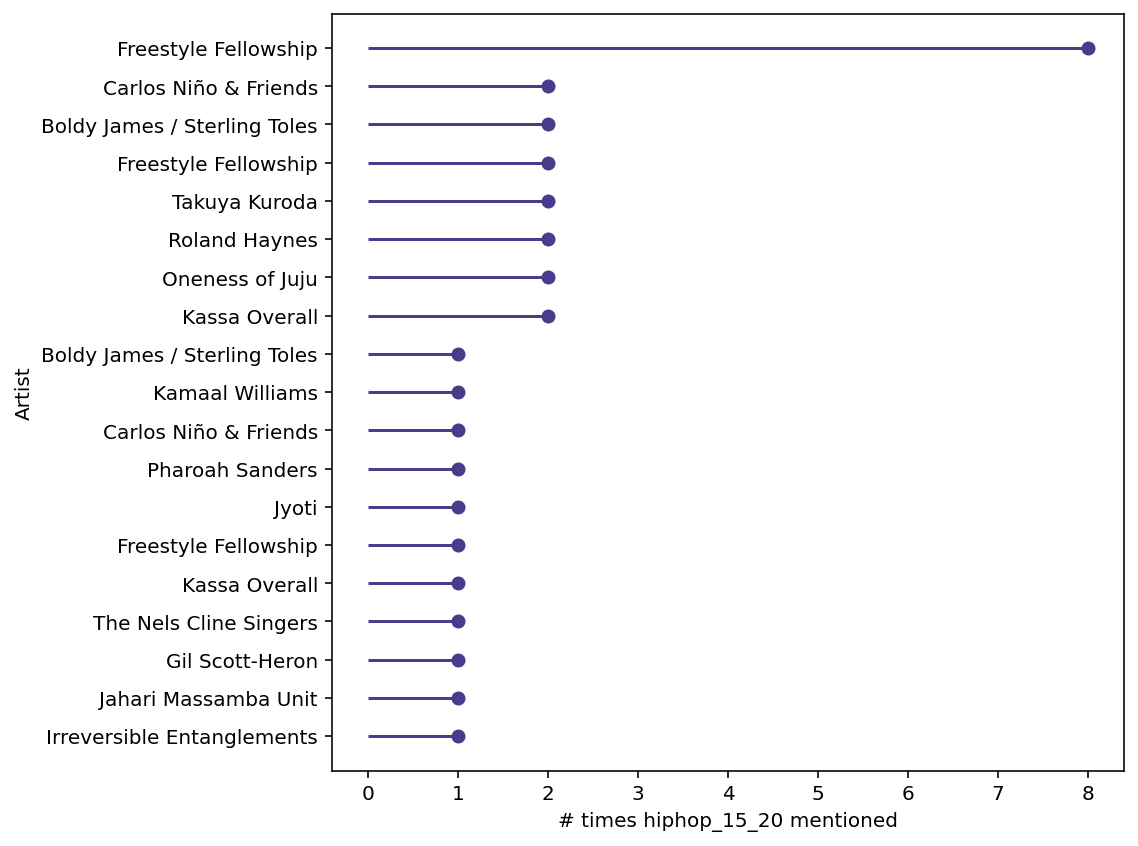

In [502]:
genplot(df_hiphop,'hiphop_15_20')

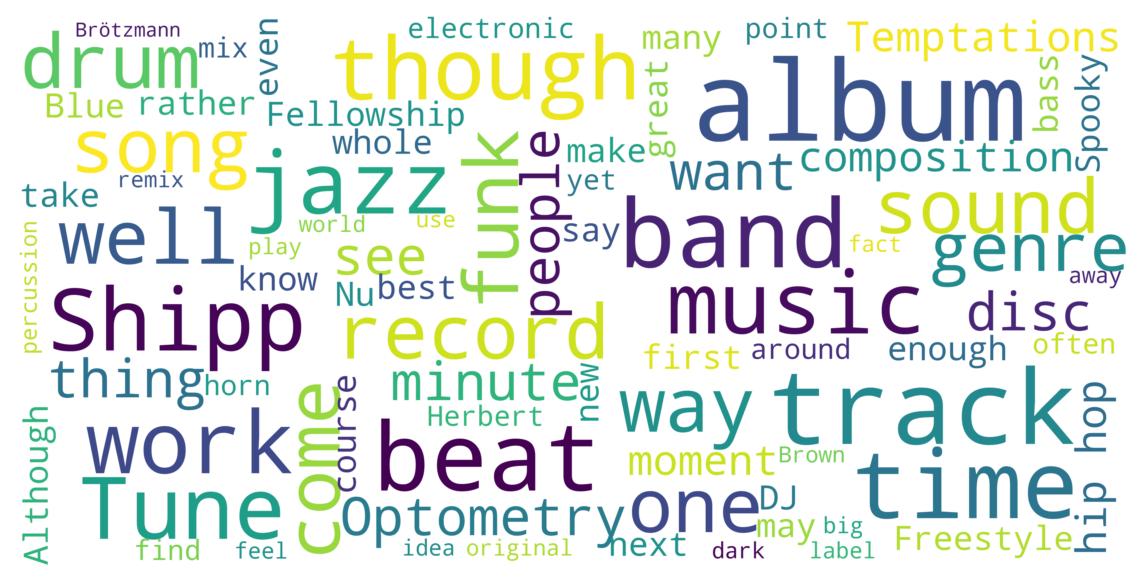

<Figure size 432x288 with 0 Axes>

In [165]:
wcloud(df_new,'hiphop')

### b. Electronic 2004

In [232]:
df_ele=gensamp(df,2,2003.0,2004.0,'electronic')

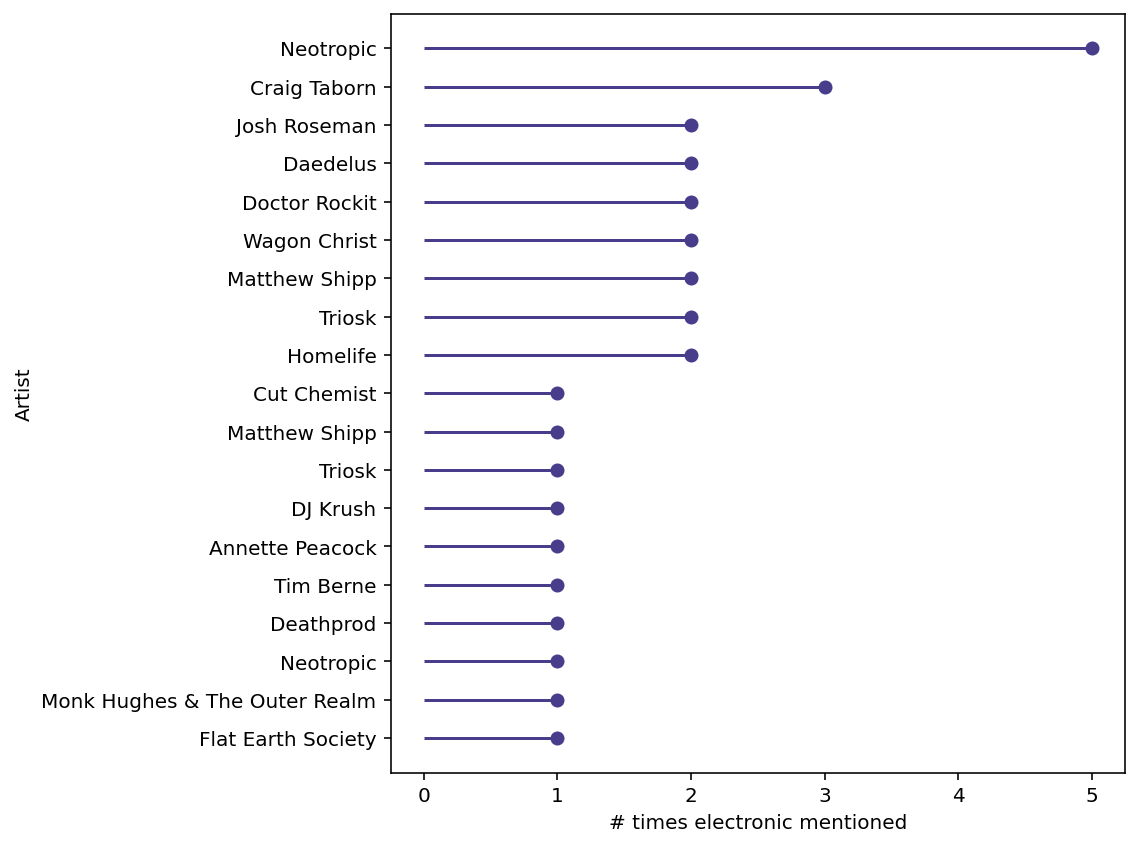

In [233]:
genplot(df_ele,'electronic')

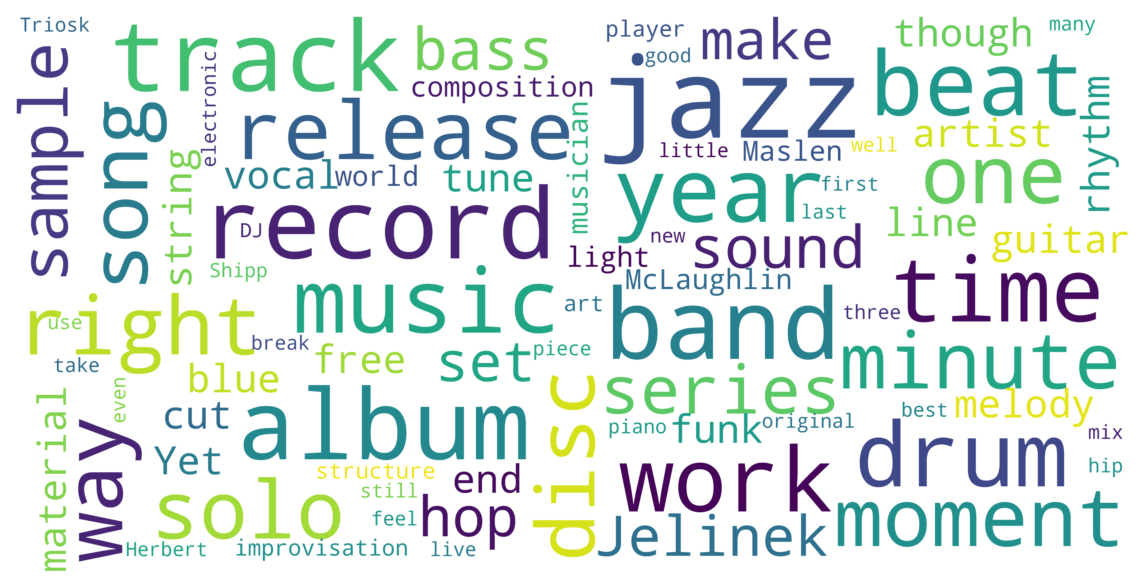

<Figure size 432x288 with 0 Axes>

In [168]:
wcloud(df_ele,'electronic')

### c. metal 2008-2013

In [234]:
df_metal=gensamp(df,2,2008.0,2013.0,'rock/metal')

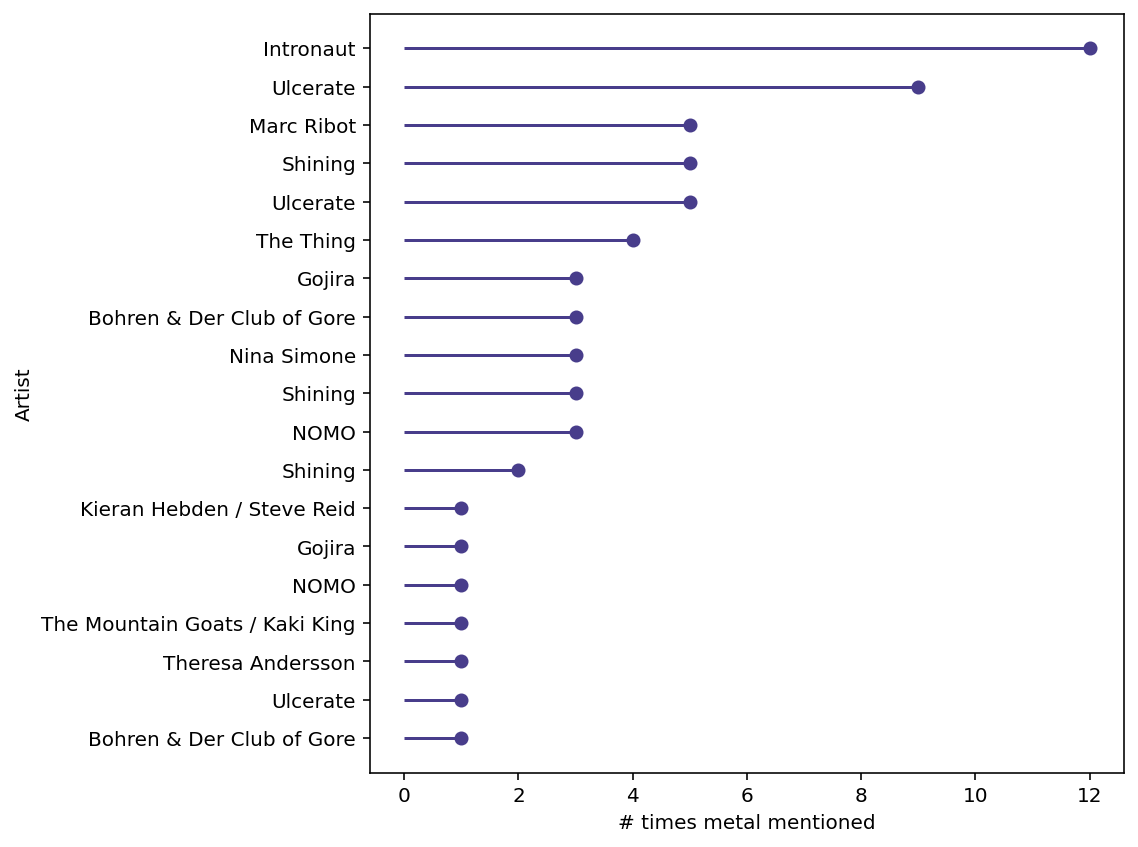

In [235]:
genplot(df_metal,'metal')

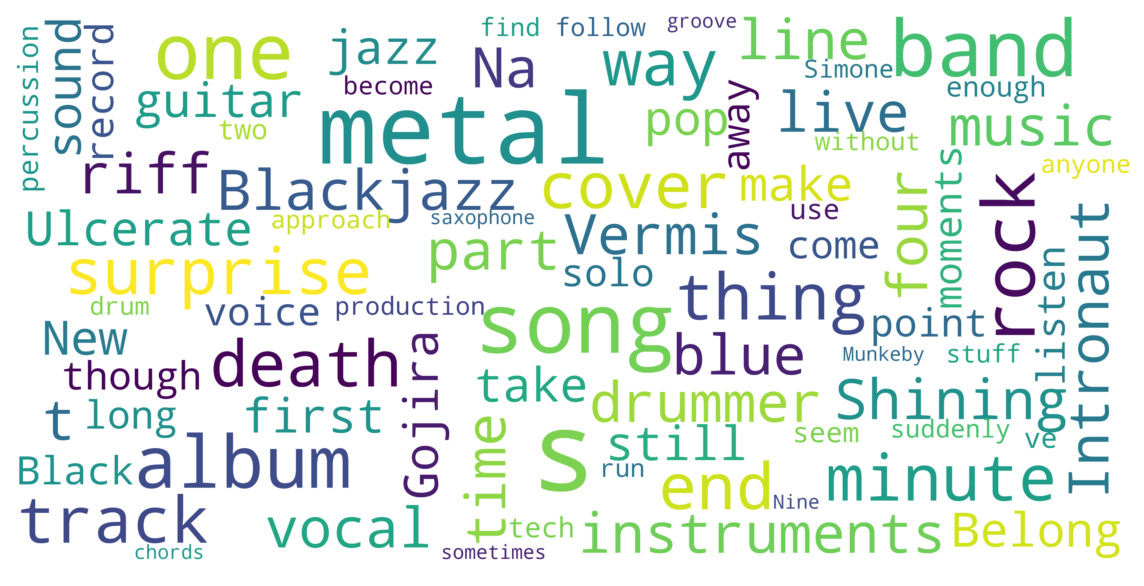

<Figure size 432x288 with 0 Axes>

In [173]:
wcloud(df_metal,'metal')

### d. Blues 2018-2020

In [174]:
df_blues=gensamp(df,2,2018.0,2020.0,'blues/soul')

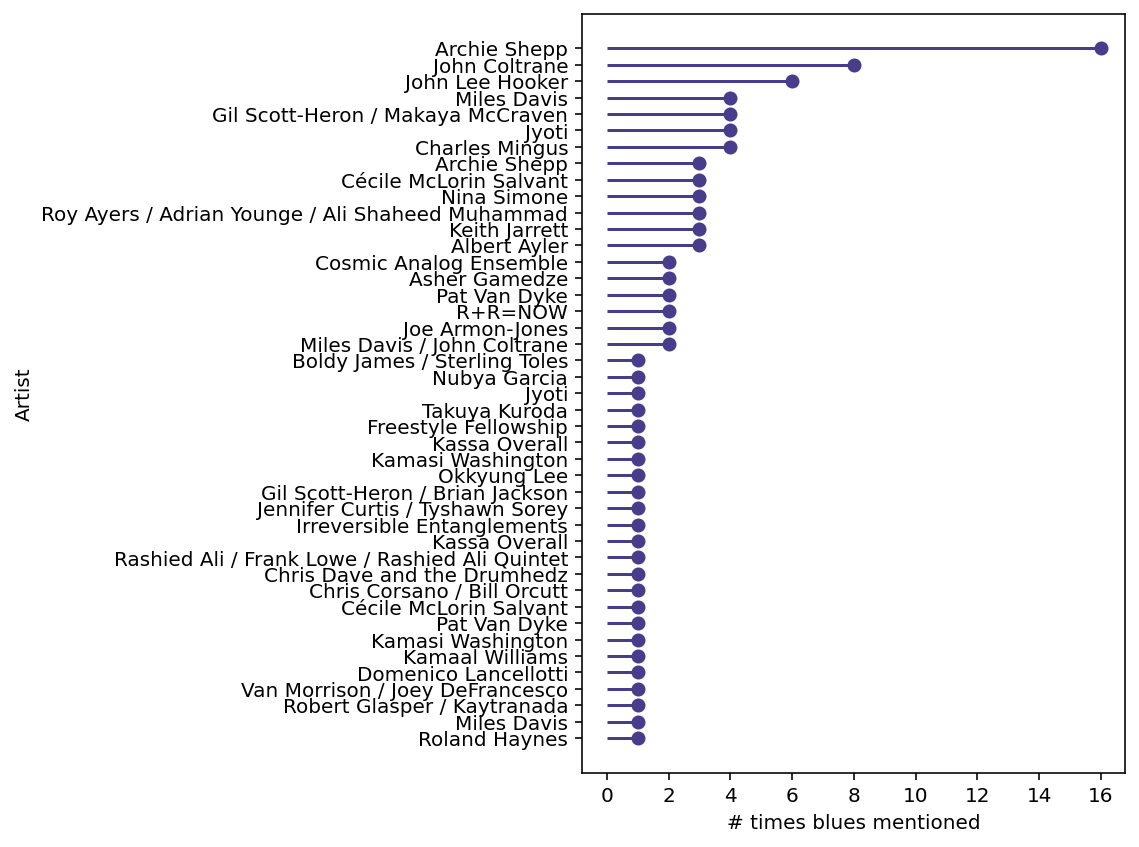

In [218]:
genplot(df_blues,'blues')

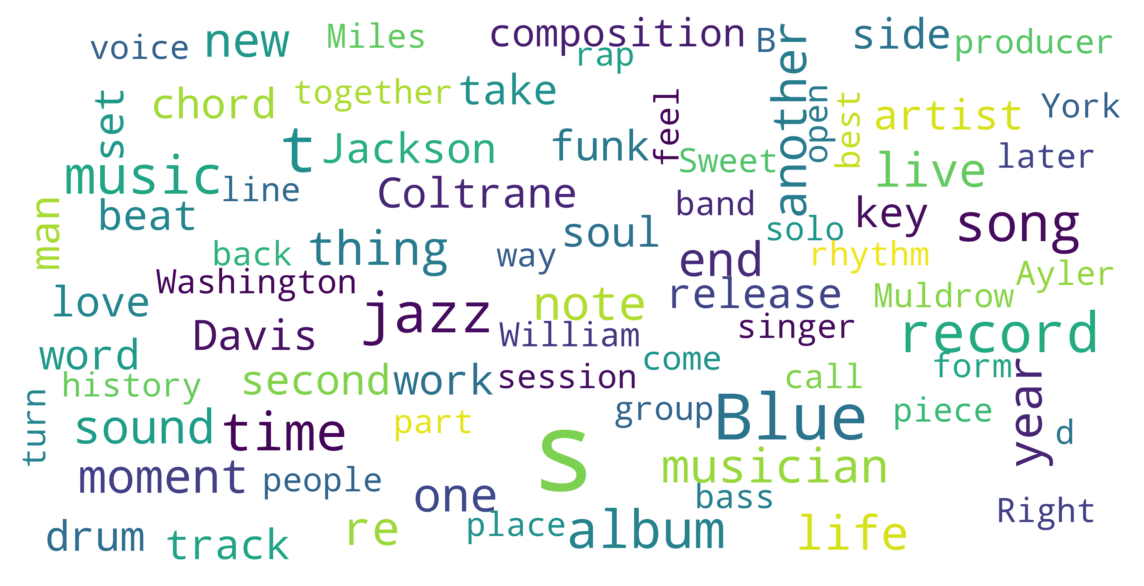

<Figure size 432x288 with 0 Axes>

In [176]:
wcloud(df_blues,'blues')

### e. Hip Hop 2015-2020

In [236]:
df_hh=gensamp(df,2,2015.0,2020.0,'hiphop/rap')

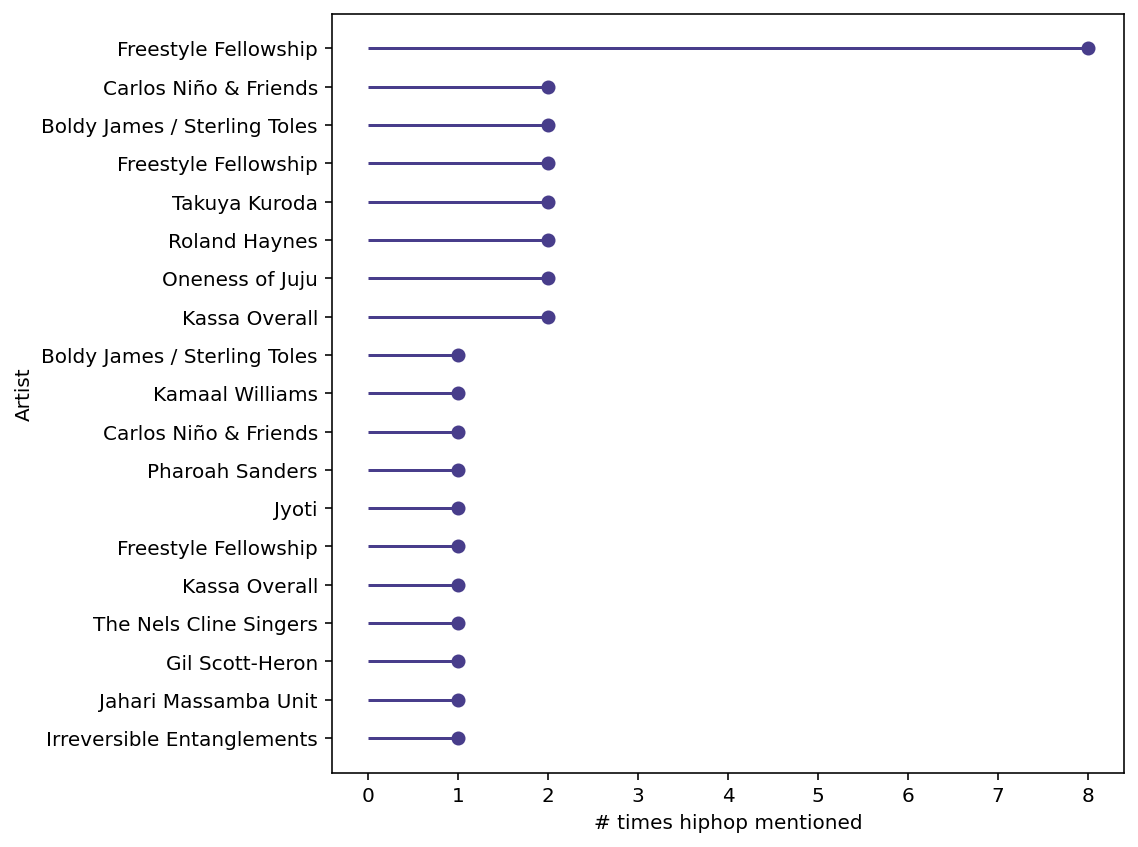

In [237]:
genplot(df_hh,'hiphop')

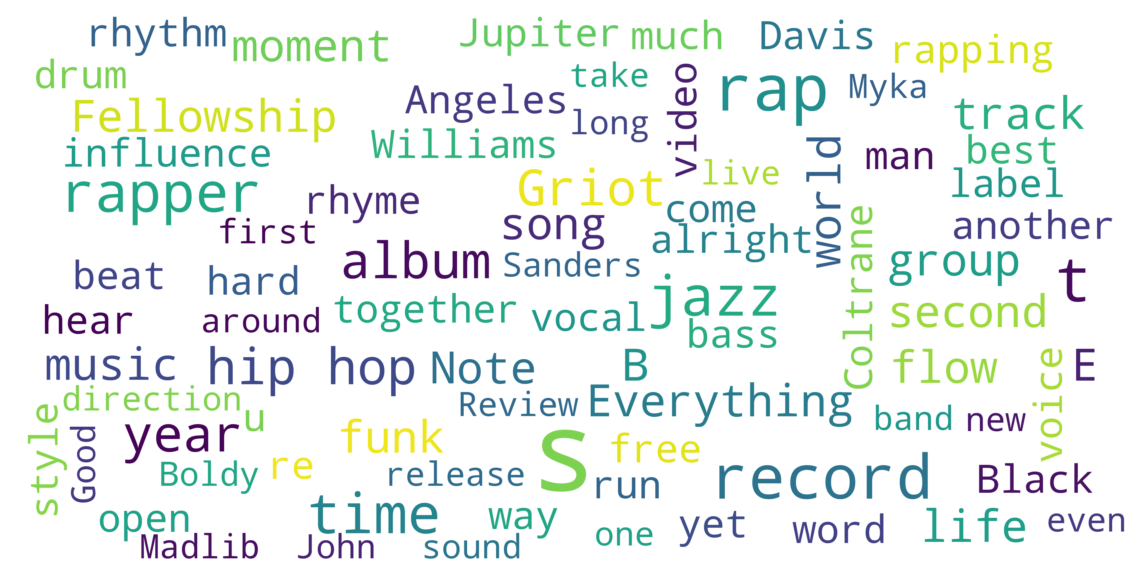

<Figure size 432x288 with 0 Axes>

In [238]:
wcloud(df_hh,'hip hop')

## EMOTION EDA

**Select the top 10 subgenres and perform sentiment emotion over time**

In [308]:
# select by genre (bigger category)
def gensampemo(data=df,gen='none'):
    df_new = data.copy()
    df_new.subgenre = df.subgenre.str.replace('^ +| +$', '')
    df_new.subgenre = df_new.subgenre.str.replace('"', '')
    df_new.subgenre = df_new.subgenre.str.replace('“', '')
    df_new.subgenre = df_new.subgenre.str.replace('”', '')
    
    df_new = df_new[(df_new['subgenre'].isin(gen))]
#    df_new2 = df_new['subgenre','year'] #,'anger', 'anticipation','disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']]
    df_new.drop_duplicates(keep=False,inplace=True) 
        
    return df_new

In [457]:
genlist = ['rock/metal','electronic','pop/r&b','hiphop/rap','blues/soul','funk/disco']
df_emo = gensampemo(df_emo_top_long_nm,genlist)
df_emo1 = df_emo[['subgenre','year','anger', 'anticipation','disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']]
df_emo1.drop_duplicates(keep=False,inplace=True) 

In [458]:
df_emo1.reset_index
df_emo1.fillna(0.00001,inplace=True)
df_emo1.head()

subgenre    year     anger  anticipation   disgust      fear       joy  \
2   hiphop/rap  2021.0  0.006126      0.026034  0.001531  0.009188  0.012251   
7   funk/disco  2021.0  0.014035      0.017544  0.010526  0.010526  0.015789   
8   hiphop/rap  2021.0  0.014035      0.017544  0.010526  0.010526  0.015789   
11  blues/soul  2021.0  0.008152      0.017663  0.001359  0.009511  0.024457   
12  electronic  2021.0  0.008571      0.017143  0.002857  0.008571  0.018571   

    negative  positive   sadness  surprise     trust  
2   0.013783  0.024502  0.012251  0.010720  0.013783  
7   0.022807  0.059649  0.017544  0.015789  0.028070  
8   0.022807  0.059649  0.017544  0.015789  0.028070  
11  0.016304  0.044837  0.025815  0.005435  0.016304  
12  0.020000  0.045714  0.021429  0.005714  0.020000

In [459]:
df_emo2=df_emo1.groupby(['subgenre','year'])[['anger', 'anticipation','disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise','trust']].mean()

In [460]:
df_emo2.reset_index(inplace=True)
#df_emo2 = df_emo2.reset_index(inplace=True)
df_emo2.head()

subgenre    year     anger  anticipation   disgust      fear       joy  \
0  blues/soul  1999.0  0.015900      0.022257  0.004324  0.013070  0.023035   
1  blues/soul  2000.0  0.010051      0.021506  0.010136  0.009196  0.021754   
2  blues/soul  2001.0  0.010450      0.020973  0.005372  0.009832  0.017672   
3  blues/soul  2002.0  0.011557      0.022158  0.007754  0.014747  0.021451   
4  blues/soul  2003.0  0.009342      0.016213  0.006075  0.012273  0.015715   

   negative  positive   sadness  surprise     trust  
0  0.032238  0.045571  0.022677  0.013081  0.020207  
1  0.030199  0.040362  0.021237  0.012479  0.026999  
2  0.019937  0.044447  0.015419  0.009083  0.019392  
3  0.032340  0.046902  0.019523  0.009751  0.025508  
4  0.027386  0.037644  0.018304  0.009139  0.019704

In [464]:
# given missing years for some genres
default = {'subgenre': '', 'year': 0.0, 'anger': 0.0001, 'anticipation': 0.0001, 'disgust': 0.0001, 'fear': 0.0001, 'joy': 0.0001, 'negative': 0.0001, 'positive': 0.0001, 'sadness': 0.0001, 'surprise': 0.0001, 'trust': 0.0001}

row = {'subgenre': 'pop/r&b', 'year': 2014}
df_emo3 = df_emo2.append({**default, **row}, ignore_index=True)

row2 = {'subgenre': 'rock/metal', 'year': 2013}
df_emo4 = df_emo3.append({**default,**row2},ignore_index=True)
df_emo4

subgenre    year     anger  anticipation   disgust      fear       joy  \
0    blues/soul  1999.0  0.015900      0.022257  0.004324  0.013070  0.023035   
1    blues/soul  2000.0  0.010051      0.021506  0.010136  0.009196  0.021754   
2    blues/soul  2001.0  0.010450      0.020973  0.005372  0.009832  0.017672   
3    blues/soul  2002.0  0.011557      0.022158  0.007754  0.014747  0.021451   
4    blues/soul  2003.0  0.009342      0.016213  0.006075  0.012273  0.015715   
..          ...     ...       ...           ...       ...       ...       ...   
133  rock/metal  2019.0  0.006741      0.022784  0.004130  0.012324  0.019852   
134  rock/metal  2020.0  0.006139      0.022562  0.003235  0.008739  0.018815   
135  rock/metal  2021.0  0.007728      0.020620  0.002289  0.007728  0.011867   
136     pop/r&b  2014.0  0.000100      0.000100  0.000100  0.000100  0.000100   
137  rock/metal  2013.0  0.000100      0.000100  0.000100  0.000100  0.000100   

     negative  positive   sadness  surprise     trust  
0    0.032238  0.045571  0.022677  0.013081  0.020207  
1    0.030199  0.040362  0.021237  0.012479  0.026999  
2    0.019937  0.044447  0.015419  0.009083  0.019392  
3    0.032340  0.046902  0.019523  0.009751  0.025508  
4    0.027386  0.037644  0.018304  0.009139  0.019704  
..        ...       ...       ...       ...       ...  
133  0.024203  0.044204  0.018261  0.008867  0.022709  
134  0.018711  0.041934  0.013559  0.009676  0.021286  
135  0.017745  0.036627  0.015017  0.007160  0.016885  
136  0.000100  0.000100  0.000100  0.000100  0.000100  
137  0.000100  0.000100  0.000100  0.000100  0.000100  

[138 rows x 12 columns]

In [465]:
df_emo4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subgenre      138 non-null    object 
 1   year          138 non-null    float64
 2   anger         138 non-null    float64
 3   anticipation  138 non-null    float64
 4   disgust       138 non-null    float64
 5   fear          138 non-null    float64
 6   joy           138 non-null    float64
 7   negative      138 non-null    float64
 8   positive      138 non-null    float64
 9   sadness       138 non-null    float64
 10  surprise      138 non-null    float64
 11  trust         138 non-null    float64
dtypes: float64(11), object(1)
memory usage: 13.1+ KB


### graph emo scores over time per subgenre

In [466]:
df_emo4.columns

Index(['subgenre', 'year', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'negative', 'positive', 'sadness', 'surprise', 'trust'],
      dtype='object')

In [467]:
#df=pd.DataFrame({'x_values': range(1,11), 'y1_values': np.random.randn(10), 'y2_values': np.random.randn(10)+range(1,11), 'y3_values': np.random.randn(10)+range(11,21) })

def emoplot(emo):
    fig = plt.figure(figsize=(8,6))
    
    # multiple line plots
    plt.plot( 'year', emo, data=df_emo2[df_emo2['subgenre'].isin(['blues/soul'])]) # , marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    plt.plot( 'year', emo, data=df_emo2[df_emo2['subgenre'].isin(['rock/metal'])]) # , marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    plt.plot( 'year', emo, data=df_emo2[df_emo2['subgenre'].isin(['funk/disco'])]) # , marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    plt.plot( 'year', emo, data=df_emo2[df_emo2['subgenre'].isin(['pop/r&b'])]) # , marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    plt.plot( 'year', emo, data=df_emo2[df_emo2['subgenre'].isin(['electronic'])]) # , marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    plt.plot( 'year', emo, data=df_emo2[df_emo2['subgenre'].isin(['hiphop/rap'])]) # , marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    # plt.plot( 'x_values', 'y2_values', data=df, marker='', color='olive', linewidth=2)
    # plt.plot( 'x_values', 'y3_values', data=df, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")
    # show legend
    # plt.yticks(my_range, ordered_df['artist'])
    #plt.title("A vertical lolipop plot", loc='left')
    plt.xlabel('Years')
    plt.ylabel(emo)
    plt.tight_layout()
    plt.savefig(f'../img/line_{emo}.png')
    plt.savefig(f'../img/line_{emo}.svg')    

    
    plt.legend()
    # show graph
    plt.show()

In [491]:
def emostack(gen):

    fig = plt.figure(figsize=(10,8))

    x=range(1998,2021)
    y1=df_emo4['anger'][df_emo4['subgenre'].isin([gen])] # , marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)]
    y2=df_emo4['fear'][df_emo4['subgenre'].isin([gen])] # , marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)]
    y3=df_emo4['joy'][df_emo4['subgenre'].isin([gen])] # , marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)]
    y4=df_emo4['surprise'][df_emo4['subgenre'].isin([gen])] # , marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)]
    y5=df_emo4['anticipation'][df_emo4['subgenre'].isin([gen])] # , marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)]
    y6=df_emo4['negative'][df_emo4['subgenre'].isin([gen])] # , marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)]
    y7=df_emo4['positive'][df_emo4['subgenre'].isin([gen])] # , marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)]    
    plt.stackplot(x,y1,y2,y3,y4,y5,y6,y7, labels=['anger','fear','joy','surprise','anticipation','negative','positive'])
    plt.legend(loc='upper right')
    
    plt.show()


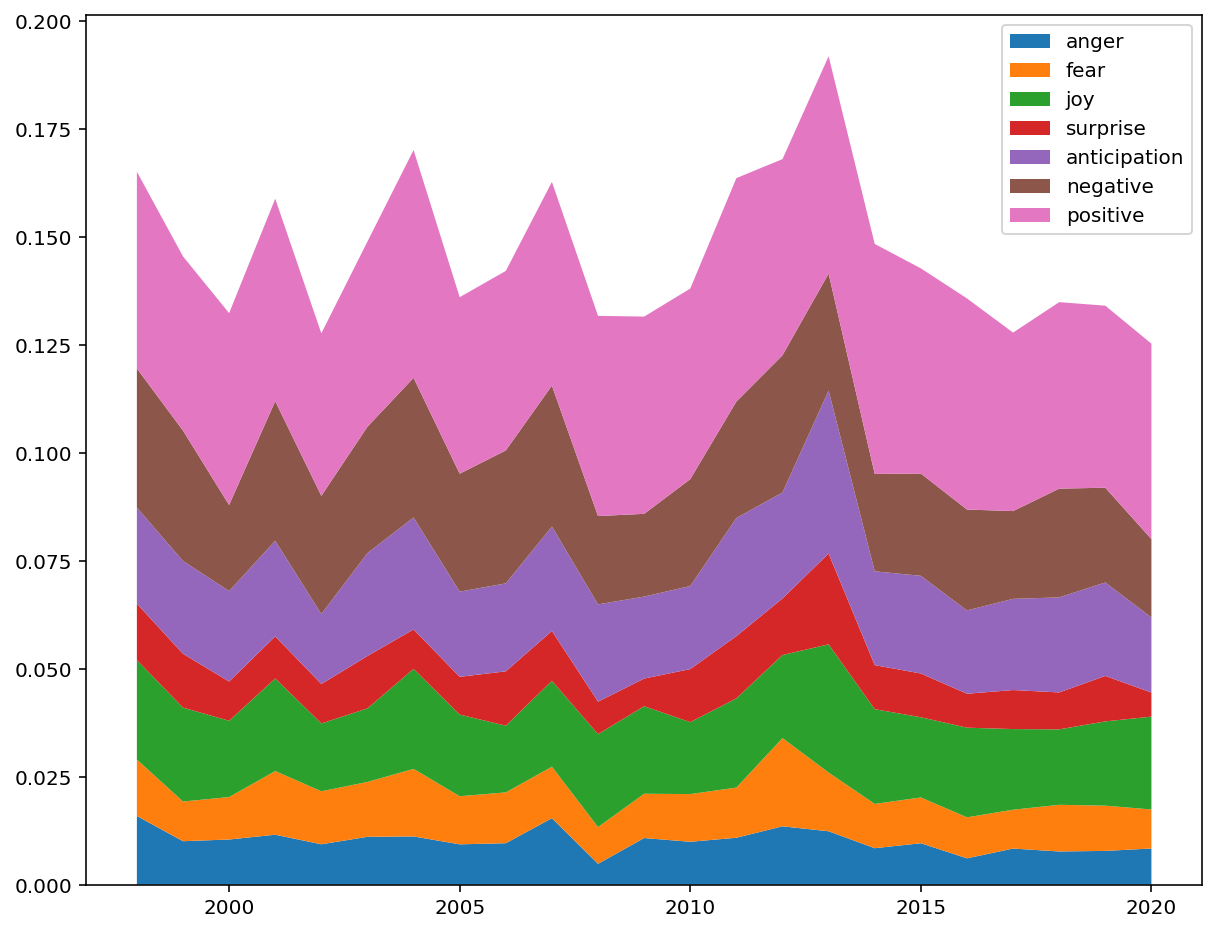

In [492]:
emostack('blues/soul')

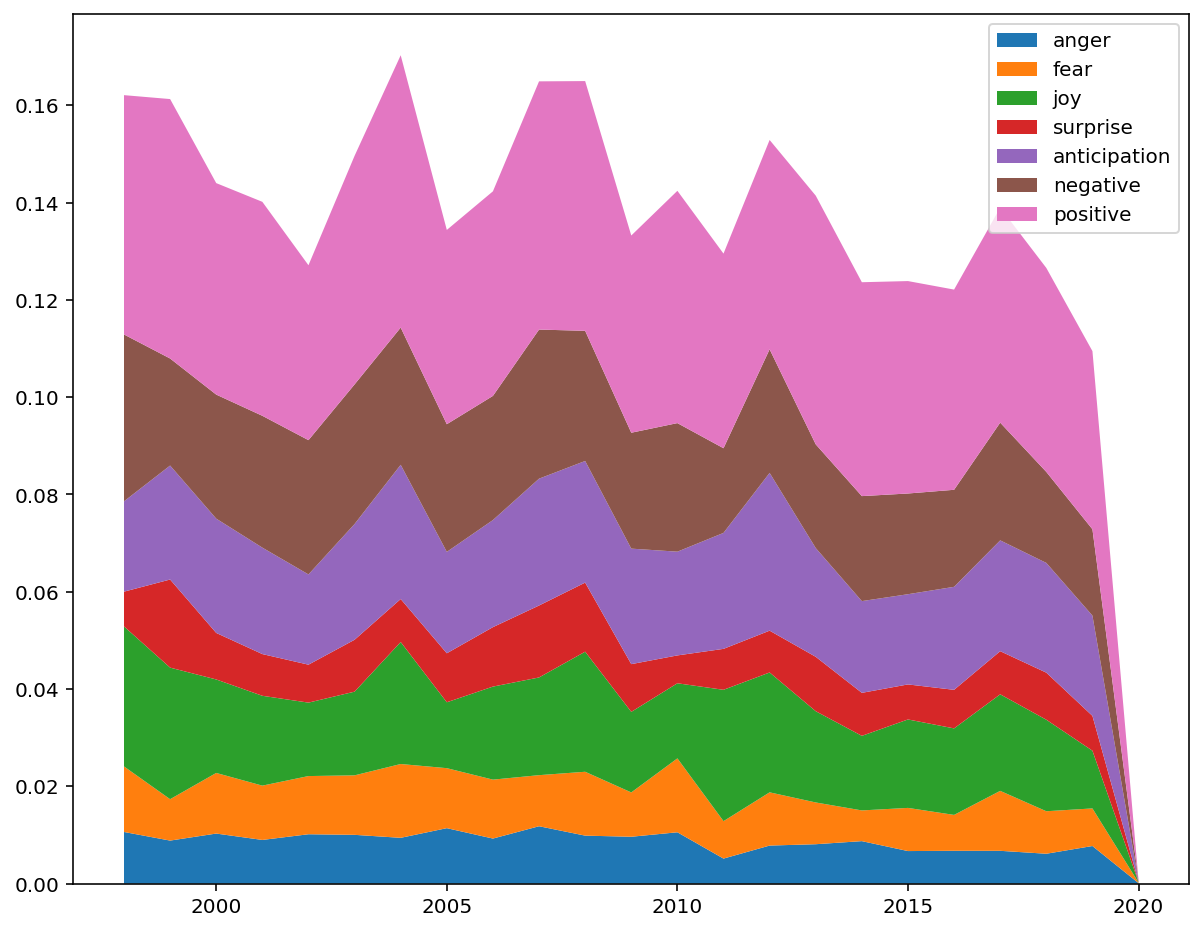

In [493]:
emostack('rock/metal')

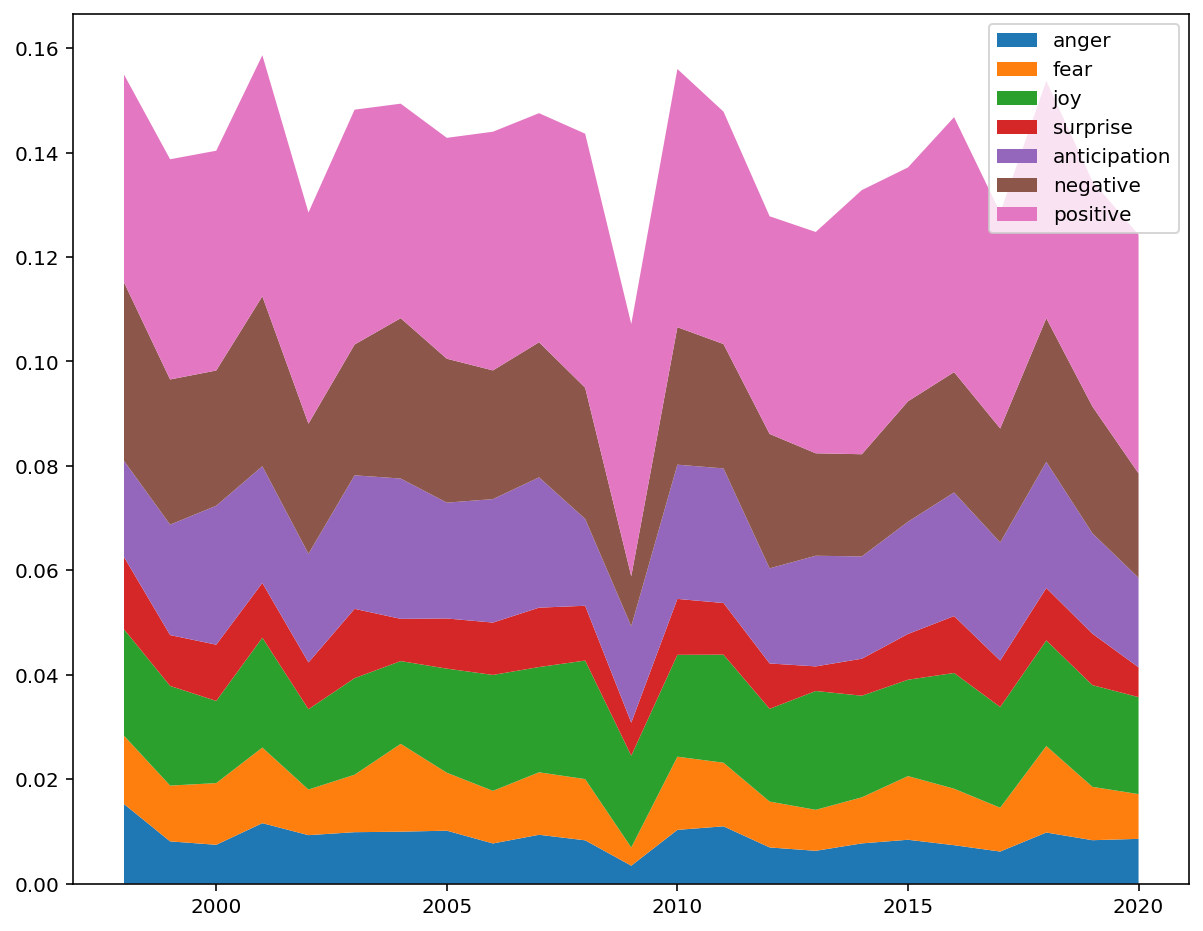

In [494]:
emostack('electronic')

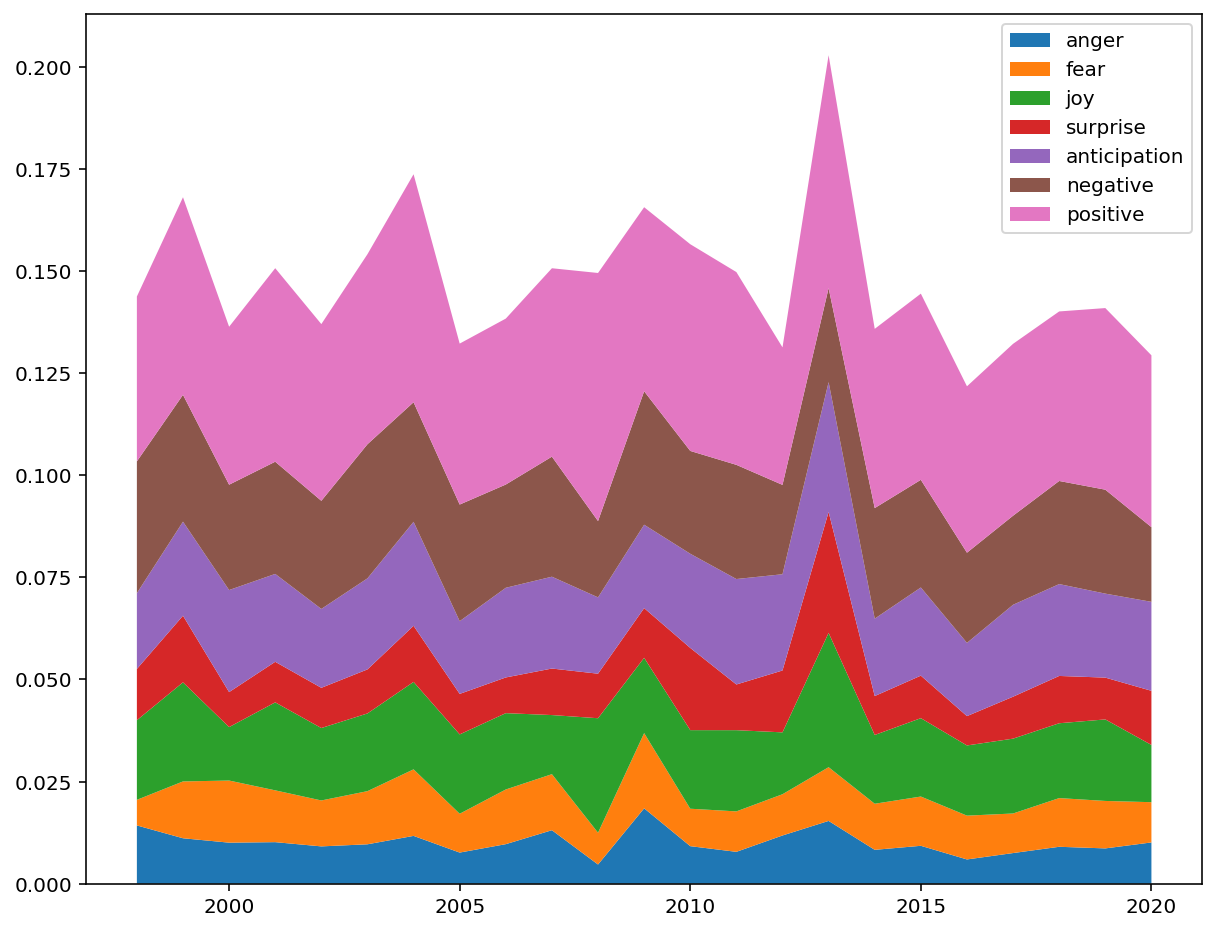

In [495]:
emostack('hiphop/rap')

### Words per Review

In [2097]:
df['totalwords'] = [len(x.split()) for x in df['review_clean'].tolist()]

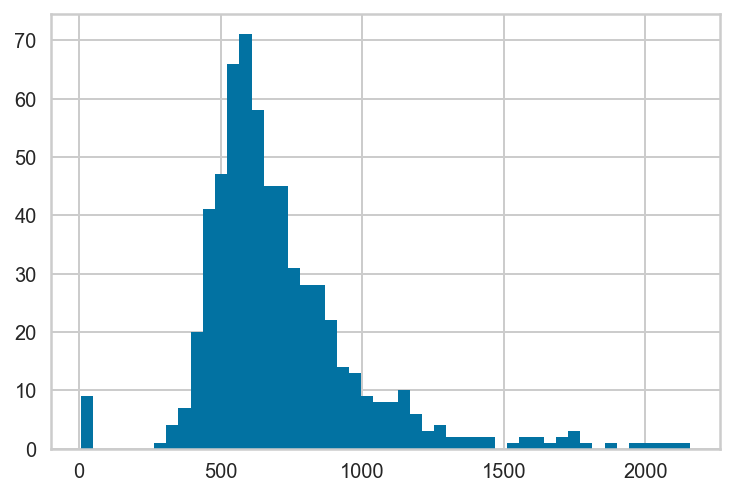

In [2098]:
%matplotlib inline
plt.hist(df['totalwords'],bins=50)
plt.show()

In [2103]:
#df['review_clean']=df['review_clean'].str.replace('"', '')
df['review_clean2'] = df['review_clean'].map(lambda x: re.sub(r'\W', ' ', x))

## EDA 
- Get value counts per genre

In [1423]:
final_database.Keyword.value_counts(1)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


jazz                 0.106478
musical              0.043187
rock                 0.036982
funk                 0.034252
pop                  0.031521
                       ...   
rap rock             0.000248
progressive rock     0.000248
boogiewoogie         0.000248
uk garage            0.000248
klezmer              0.000248
Name: Keyword, Length: 225, dtype: float64

In [1424]:
gen_count=final_database.Keyword.value_counts()
type(gen_count)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


pandas.core.series.Series

In [1425]:
gen_count.to_csv(r'../data/gen_counts.csv')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Viz Ideas - Heatmap - Genre over time<br>
Word cloud of genres**

In [1428]:
final_database.head()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


album Subject     Keyword Count
0    0.0   Stats       jazz      2
1    0.0   Stats  free jazz      1
2    0.0   Stats  cloud rap      1
3    0.0   Stats   chiptune      1
4    0.0   Stats    ambient      2

### Bring in review dates - left join the main DF

**rename columns for merge**

In [1447]:
df.rename(columns={'Unnamed: 0': 'revID'} , inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1448]:
final_database.rename(columns={'album': 'revID'} , inplace=True)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1498]:
#test2 = test2["revID"].astype(int)
df_long=final_database.merge(df, on='revID', how='left')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1499]:
df_long_limited=df_long[['Keyword','Count','revdate']]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1500]:
df_long_limited['year'] = df_long_limited['revdate'].dt.year
df_long_limited.drop(['revdate'],axis=1,inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1501]:
df_long_limited.head(2)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Keyword Count    year
0       jazz      2  2021.0
1  free jazz      1  2021.0

In [1502]:
df_long_limited.fillna(0,inplace=True)
df_long_limited['Count']=df_long_limited['Count'].astype(str).astype(int)
df_long_limited.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4040 entries, 0 to 4039
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Keyword  4040 non-null   object 
 1   Count    4040 non-null   int64  
 2   year     4040 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 126.2+ KB


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Group by and Pivot to make genres columns**

In [1472]:
# Gropu by year
x=df_long_limited.groupby(['year']).sum()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2042]:
genre_time=pd.pivot_table(df_long_limited, index = 'year', values = 'Count', columns = 'Keyword', aggfunc = 'sum')
genre_time.fillna(0,inplace=True)
genre_time.drop((0.0),inplace=True)
genre_time

Keyword    0  acid house   acid jazz   acid rock   acoustic blues   afrobeat   \
year                                                                            
1999.0   0.0          0.0         0.0         0.0              0.0        0.0   
2000.0   0.0          0.0         1.0         0.0              0.0        0.0   
2001.0   0.0          0.0         0.0         0.0              0.0        0.0   
2002.0   0.0          0.0         0.0         0.0              0.0        0.0   
2003.0   0.0          0.0         2.0         0.0              0.0        2.0   
2004.0   0.0          0.0         2.0         0.0              0.0        6.0   
2005.0   0.0          0.0         0.0         0.0              0.0        5.0   
2006.0   0.0          0.0         0.0         0.0              0.0        1.0   
2007.0   0.0          0.0         0.0         0.0              0.0        2.0   
2008.0   0.0          0.0         0.0         0.0              0.0        5.0   
2009.0   0.0          0.0         0.0         0.0              0.0        1.0   
2010.0   0.0          0.0         0.0         0.0              0.0        1.0   
2011.0   0.0          0.0         0.0         0.0              0.0        0.0   
2012.0   0.0          0.0         0.0         0.0              0.0        0.0   
2013.0   0.0          0.0         0.0         0.0              0.0        0.0   
2014.0   0.0          0.0         0.0         0.0              0.0        0.0   
2015.0   0.0          0.0         0.0         0.0              0.0        0.0   
2016.0   0.0          1.0         0.0         0.0              0.0        1.0   
2017.0   0.0          0.0         1.0         0.0              0.0        0.0   
2018.0   0.0          0.0         0.0         0.0              0.0       10.0   
2019.0   0.0          0.0         0.0         0.0              0.0        2.0   
2020.0   0.0          0.0         0.0         1.0              1.0       10.0   
2021.0   0.0          0.0         0.0         0.0              0.0        4.0   

Keyword  ambient   ambient techno   americana   art rock   ...  trap   \
year                                                       ...          
1999.0        0.0              0.0         0.0        0.0  ...    0.0   
2000.0        4.0              0.0         0.0        0.0  ...    0.0   
2001.0        3.0              0.0         0.0        0.0  ...    0.0   
2002.0       10.0              0.0         1.0        0.0  ...    2.0   
2003.0        7.0              0.0         0.0        0.0  ...    0.0   
2004.0       12.0              0.0         1.0        0.0  ...    2.0   
2005.0        5.0              0.0         0.0        1.0  ...    1.0   
2006.0        2.0              0.0         0.0        0.0  ...    0.0   
2007.0        4.0              0.0         0.0        0.0  ...    0.0   
2008.0        3.0              0.0         0.0        0.0  ...    0.0   
2009.0        6.0              0.0         0.0        0.0  ...    0.0   
2010.0        1.0              0.0         0.0        0.0  ...    0.0   
2011.0        7.0              1.0         0.0        1.0  ...    0.0   
2012.0        1.0              0.0         0.0        0.0  ...    0.0   
2013.0        1.0              0.0         0.0        0.0  ...    0.0   
2014.0        1.0              0.0         0.0        0.0  ...    0.0   
2015.0        3.0              0.0         0.0        0.0  ...    0.0   
2016.0        3.0              0.0         0.0        0.0  ...    0.0   
2017.0       19.0              0.0         0.0        0.0  ...    3.0   
2018.0       12.0              0.0         1.0        0.0  ...    0.0   
2019.0        8.0              1.0         0.0        0.0  ...    0.0   
2020.0        7.0              0.0         0.0        0.0  ...    2.0   
2021.0        4.0              0.0         0.0        0.0  ...    0.0   

Keyword  trip hop   turntablism   uk garage   underground hiphop   \
year                                                                
1999.0    

In [2055]:
# remove jazz
genre_time.columns = genre_time.columns.str.strip()
genre_time_limited=genre_time.drop('jazz',axis=1)
# transpose
genre_time_T = genre_time_limited.T
genre_time_T = genre_time_T.iloc[1:]
genre_time_T

year               1999.0  2000.0  2001.0  2002.0  2003.0  2004.0  2005.0  \
Keyword                                                                     
acid house            0.0     0.0     0.0     0.0     0.0     0.0     0.0   
acid jazz             0.0     1.0     0.0     0.0     2.0     2.0     0.0   
acid rock             0.0     0.0     0.0     0.0     0.0     0.0     0.0   
acoustic blues        0.0     0.0     0.0     0.0     0.0     0.0     0.0   
afrobeat              0.0     0.0     0.0     0.0     2.0     6.0     5.0   
...                   ...     ...     ...     ...     ...     ...     ...   
vocal house           0.0     0.0     0.0     0.0     1.0     0.0     0.0   
vocal jazz            0.0     0.0     0.0     0.0     0.0     0.0     0.0   
waltz                 0.0     0.0     0.0     2.0     0.0     1.0     0.0   
west coast hiphop     0.0     0.0     0.0     3.0     0.0     0.0     0.0   
western swing         0.0     0.0     0.0     0.0     0.0     0.0     0.0   

year               2006.0  2007.0  2008.0  ...  2012.0  2013.0  2014.0  \
Keyword                                    ...                           
acid house            0.0     0.0     0.0  ...     0.0     0.0     0.0   
acid jazz             0.0     0.0     0.0  ...     0.0     0.0     0.0   
acid rock             0.0     0.0     0.0  ...     0.0     0.0     0.0   
acoustic blues        0.0     0.0     0.0  ...     0.0     0.0     0.0   
afrobeat              1.0     2.0     5.0  ...     0.0     0.0     0.0   
...                   ...     ...     ...  ...     ...     ...     ...   
vocal house           0.0     0.0     0.0  ...     0.0     0.0     0.0   
vocal jazz            0.0     0.0     0.0  ...     0.0     0.0     0.0   
waltz                 0.0     0.0     0.0  ...     0.0     0.0     0.0   
west coast hiphop     0.0     0.0     0.0  ...     0.0     0.0     0.0   
western swing         1.0     0.0     0.0  ...     0.0     0.0     0.0   

year               2015.0  2016.0  2017.0  2018.0  2019.0  2020.0  2021.0  
Keyword                                                                    
acid house            0.0     1.0     0.0     0.0     0.0     0.0     0.0  
acid jazz             0.0     0.0     1.0     0.0     0.0     0.0     0.0  
acid rock             0.0     0.0     0.0     0.0     0.0     1.0     0.0  
acoustic blues        0.0     0.0     0.0     0.0     0.0     1.0     0.0  
afrobeat              0.0     1.0     0.0    10.0     2.0    10.0     4.0  
...                   ...     ...     ...     ...     ...     ...     ...  
vocal house           0.0     0.0     0.0     0.0     0.0     0.0     0.0  
vocal jazz            0.0     0.0     0.0     2.0     0.0     0.0     0.0  
waltz                 0.0     1.0     0.0     0.0     1.0     2.0     0.0  
west coast hiphop     0.0     0.0     0.0     0.0     0.0     2.0     0.0  
western swing         0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[224 rows x 23 columns]

### Data viz - heatmap of genre over time

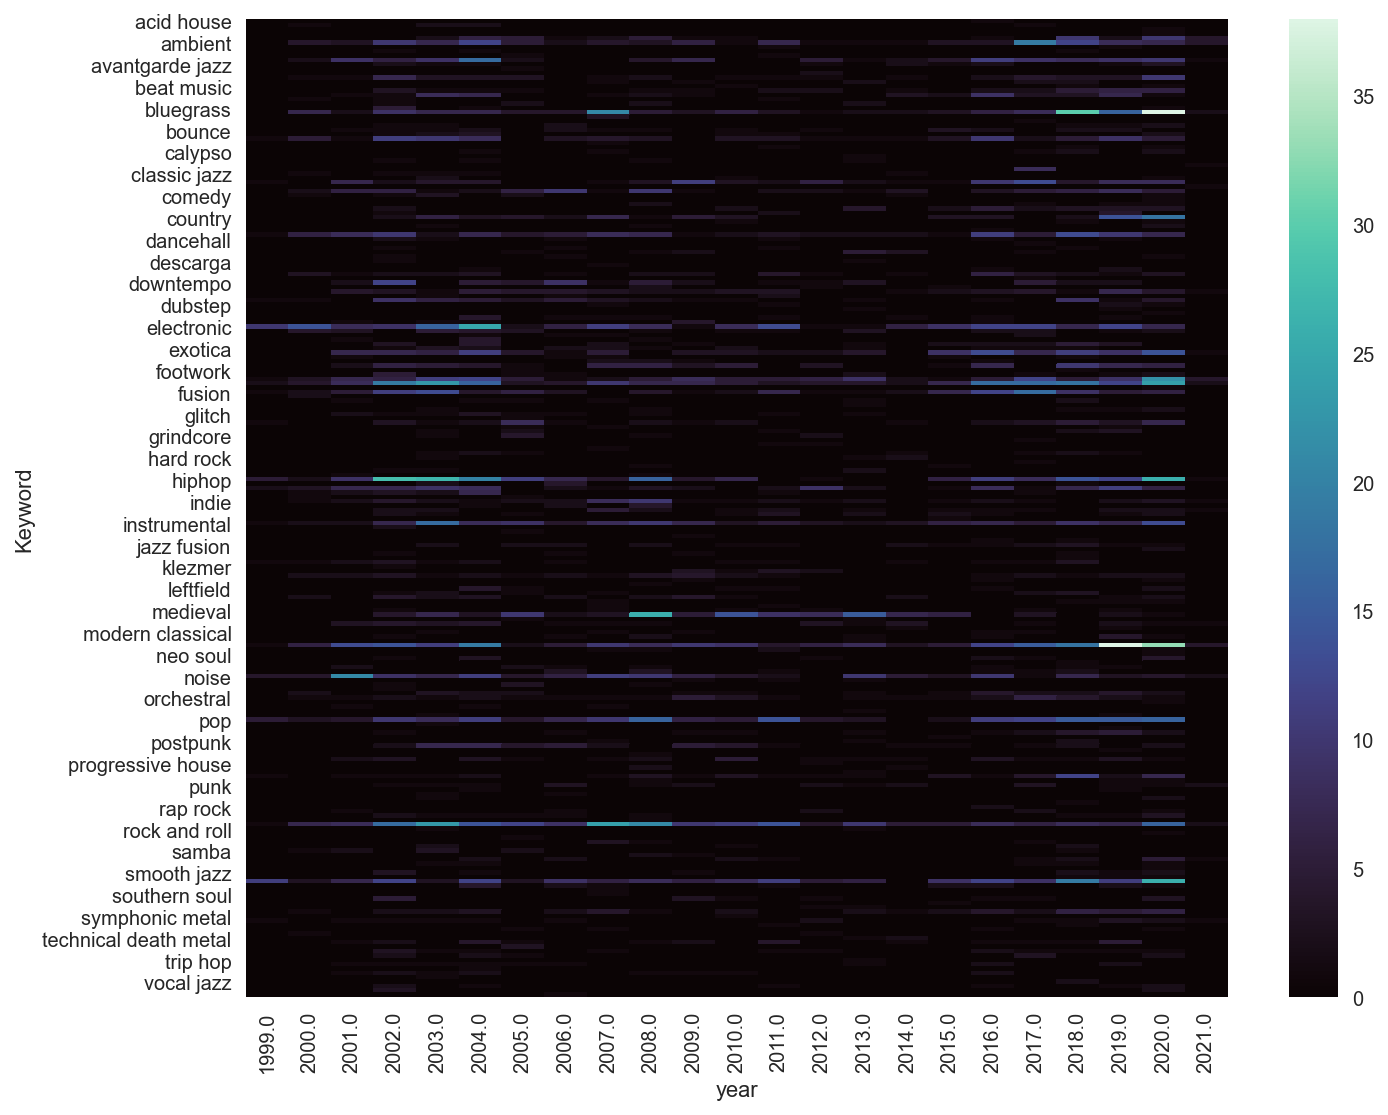

In [2056]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(genre_time_T,fmt="d", cmap="mako")
plt.show()

**Take only the top 30 genres**

In [2497]:
# sum across columns
genre_time_T['total_genres'] = genre_time_T.sum(axis=1)

# sort by total
genre_time_T_top30=genre_time_T.sort_values(by=['total_genres'],ascending=False).nlargest(30, 'total_genres')

# take top 30
genre_time_T_top30.drop(['total_genres'],axis=1,inplace=True)

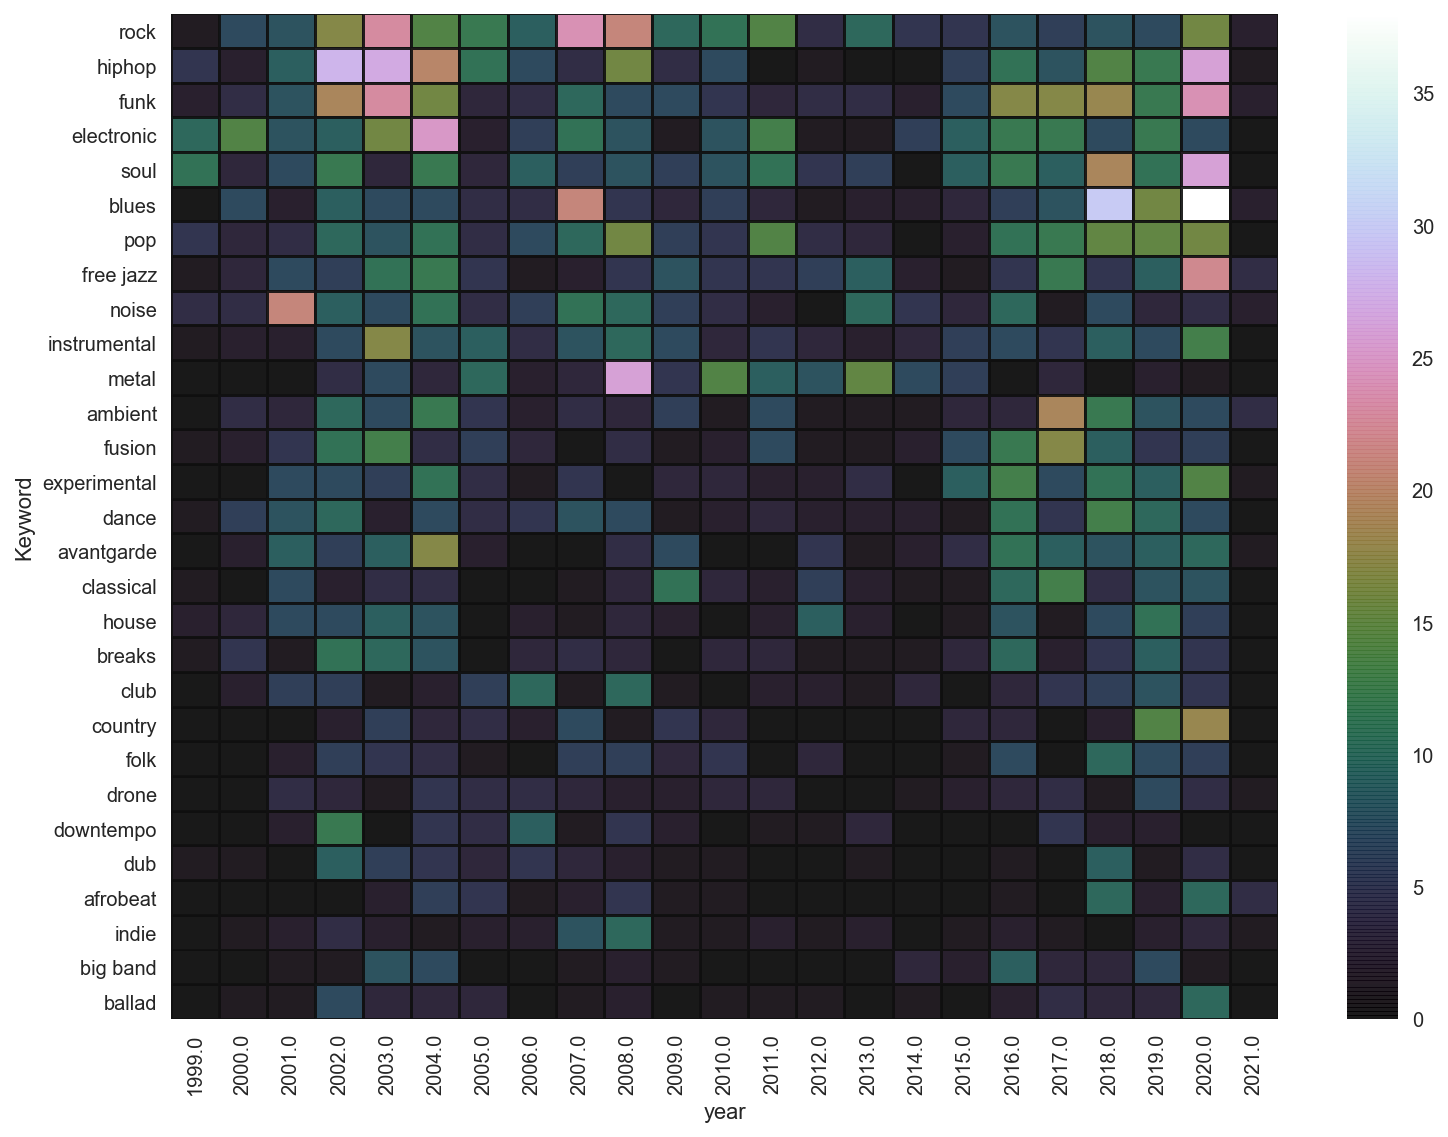

In [2498]:
gentime_df_rmv = genre_time_T_top30[1:]

fig, ax = plt.subplots(figsize=(11, 8))
#cmap= sns.cubehelix_palette()
kwargs = {'alpha':.9,'linewidth':1, 'linestyle':'-', 'linecolor':'k','rasterized':False, 'edgecolor':'w', "capstyle":'projecting',}
sns.heatmap(gentime_df_rmv, cmap='cubehelix', **kwargs )
plt.tight_layout()
plt.savefig('../img/heatmap_subgenre.png')

**Output to csv**

In [2424]:
genre_time_T_top30.to_csv('../data/df_genre_time.csv')

### More EDA on genres over time
- pull artist names and albums for specified timeframes

### Count top words used in reviews
- top 20 over time

In [2137]:
mystops = nltk.corpus.stopwords.words('english')
mystops.extend(my_stop_words)

In [2201]:
stopadd = ['like','electronic','experimental','pop/r&b','rock','rough','trade','soundcloud','rap','j','&','metal','global']
mystops.extend(stopadd)

In [2310]:
# THis is a list from raw data = obtaining named entities from reviews!
# file = open('../data/rev_corp_test.txt', encoding="utf8")
# a= file.read()
test = pd.read_csv('../data/rev_corp_test.txt', encoding="utf8")

In [2327]:
# strip blank spaces and other nums after periods
res = [] 
for ele in test:
    x=ele.split(".",1)
    y=x[0]
    z=y.strip()
    res.append(z)

In [2328]:
res

['Sam Gendel',
 'Jay Balfour',
 'Sam Gendel',
 'covered',
 'Ocarina of Time',
 '4444',
 'Champs EÃÅlyseÃÅes',
 'Femi Kuti',
 'Made Kuti',
 'Joey Akan',
 'Global',
 'Fela Kuti',
 'Afrobeat',
 'Seun Kuti',
 'Femi Kuti',
 'Made',
 'Archie Shepp',
 'Jason Moran',
 'Madison Bloom',
 'Archie Shepp',
 'Let My People Go',
 'Jason Moran',
 'said',
 'recorded an album',
 'Patricia Brennan',
 'Daniel Felsenthal',
 'Experimental',
 'Patricia Brennan',
 'Baldi/Gerycz Duo',
 'Fred Thomas',
 'Experimental',
 'Cloud Nothings',
 'jams',
 'several',
 'abstract',
 'side projects',
 'Pharoah Sanders',
 'Blessed Repair',
 'Duo Exchange',
 'Roland Haynes',
 'Marty Sartini Garner',
 'Roland Haynes',
 'Pharoah Sanders',
 'Jandek',
 'DJ Khaled',
 'Association for the Advancement of Creative Musicians',
 'Archie Shepp',
 'Alice Coltrane',
 'Herbie Hancock',
 'Head Hunters',
 'Jimi Hendrix',
 'Flying Lotus',
 'Chick Corea',
 'Grateful Dead',
 'Rough Trade',
 'Winston C',
 'Connor Beckett McInerney',
 'Pop/R&B',


In [2333]:
remwords = ['Electronic', 'Experimental','Pop/R&B', 'Rock','Rough Trade', 'SoundCloud', 'Rap', 'Metal','Global','','Seth Colter Walls',
           'Mark Richardson','Joe Tangari','Andy Beta','Dominique Leone','Chris Dahlen', 'Brian Howe','Marc Masters','Paul Cooper',
            'Grayson Currin','Matthew Murphy','Marcus J','Nate Patrin','Mike Powell','Marty Sartini Garner', 'Kind of Blue','Jonathan Zwickel',
            'Jay Balfour','Bitches Brew','Dean Van Nguyen','Grayson Haver Currin' ,'Steve Lehman','Matthew Kassel','Folk/Country','Nate Chinen'
            'Phillip Mlynar' ,'Mark Martelli','Daniel Felsenthal','Steven Arroyo','A Love Supreme']

for word in list(res):  # iterating on a copy since removing will mess things up
    if word in remwords:
        res.remove(word)

In [2334]:
from collections import Counter
counts = Counter(res)
#counts.most_common(3)
print(counts)

Counter({'Miles Davis': 49, 'John Coltrane': 40, 'Sun Ra': 23, 'Kamasi Washington': 23, 'Pharoah Sanders': 21, 'Alice Coltrane': 21, 'Thundercat': 20, 'Ornette Coleman': 20, 'Nina Simone': 18, 'Robert Glasper': 17, 'Cecil Taylor': 16, 'Herbie Hancock': 15, 'John Zorn': 15, 'Anthony Braxton': 14, 'Flying Lotus': 13, 'Makaya McCraven': 13, 'Duke Ellington': 13, 'Mary Halvorson': 13, 'Vijay Iyer': 12, 'Daedelus': 12, 'Kendrick Lamar': 11, 'Albert Ayler': 11, 'Charles Mingus': 11, 'J Dilla': 10, 'Jeff Parker': 10, 'Matthew Shipp': 10, 'Gil Scott-Heron': 9, 'Thelonious Monk': 9, 'Shabaka Hutchings': 9, 'Esperanza Spalding': 9, 'Craig Taborn': 9, 'Wadada Leo Smith': 9, 'Amon Tobin': 9, 'Zs': 9, 'Don Cherry': 8, 'Brian Eno': 8, 'Christian Scott aTunde Adjuah': 8, 'Four Tet': 8, 'Eric Dolphy': 7, 'Okkyung Lee': 7, 'Stevie Wonder': 7, 'Chet Baker': 7, 'Nels Cline': 7, 'Bonobo': 7, 'Billie Holiday': 7, 'Sam Gendel': 6, 'Piotr Orlov': 6, 'Tomeka Reid': 6, 'Nate Chinen': 6, 'Art Ensemble of Chicag

How many most common words to print: 50

OK. The 50 most common words are as follows

Miles Davis :  49
John Coltrane :  40
Sun Ra :  23
Kamasi Washington :  23
Pharoah Sanders :  21
Alice Coltrane :  21
Thundercat :  20
Ornette Coleman :  20
Nina Simone :  18
Robert Glasper :  17
Cecil Taylor :  16
Herbie Hancock :  15
John Zorn :  15
Anthony Braxton :  14
Flying Lotus :  13
Makaya McCraven :  13
Duke Ellington :  13
Mary Halvorson :  13
Vijay Iyer :  12
Daedelus :  12
Kendrick Lamar :  11
Albert Ayler :  11
Charles Mingus :  11
J Dilla :  10
Jeff Parker :  10
Matthew Shipp :  10
Gil Scott-Heron :  9
Thelonious Monk :  9
Shabaka Hutchings :  9
Esperanza Spalding :  9
Craig Taborn :  9
Wadada Leo Smith :  9
Amon Tobin :  9
Zs :  9
Don Cherry :  8
Brian Eno :  8
Christian Scott aTunde Adjuah :  8
Four Tet :  8
Eric Dolphy :  7
Okkyung Lee :  7
Stevie Wonder :  7
Chet Baker :  7
Nels Cline :  7
Bonobo :  7
Billie Holiday :  7
Sam Gendel :  6
Piotr Orlov :  6
Tomeka Reid :  6
Nate Chinen 

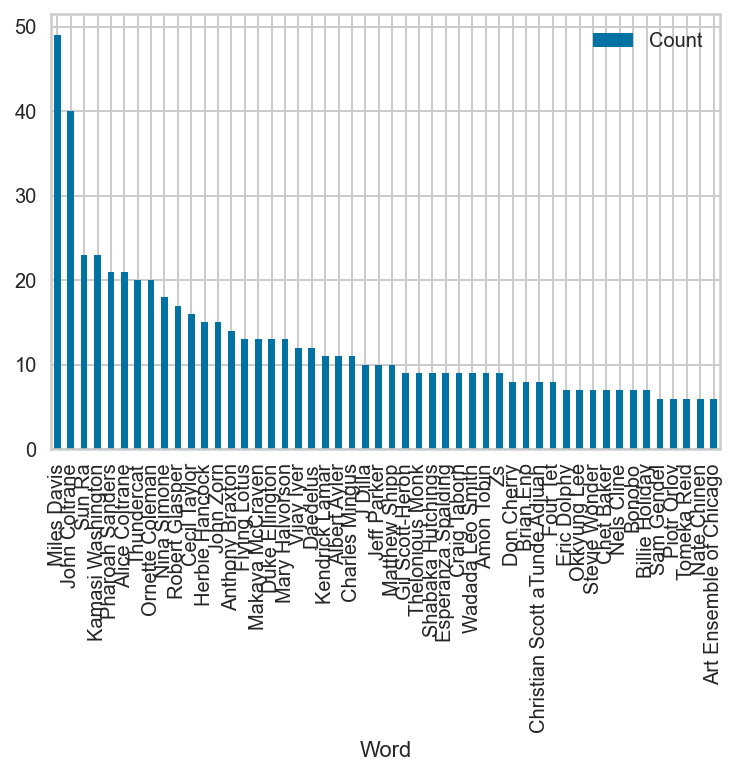

In [2425]:
import collections
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Read input file, note the encoding is specified here 
# It may be different in your text file
# file = open('../data/rev_corp_test.txt', encoding="utf8")
# a= file.read()
# Stopwords

# stopwords = set(line.strip() for line in open('stopwords.txt'))
# stopwords = stopwords.union(set(['mr','mrs','one','two','said']))
# Instantiate a dictionary, and for every word in the file, 
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}

# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in res: # a.lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace(":","")
    word = word.replace("\"","")
    word = word.replace("!","")
    word = word.replace("â€œ","")
    word = word.replace("â€˜","")
    word = word.replace("*","")
    if word not in mystops: #my_stop_words: #stopwords:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)

for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)

# Close the file
#file.close()
# Create a data frame of the most common words 
# Draw a bar chart
lst = word_counter.most_common(n_print)
dfwords = pd.DataFrame(lst, columns = ['Word', 'Count'])
dfwords.plot.bar(x='Word',y='Count')

### Output DF to CSV for EDA Graph

In [2433]:
dfwords.to_csv('../data/df_top_mentions.csv')

**Testing different cuts of data**

In [2426]:
def topmention(x=50):
    dfment=dfwords[0:x]
    return dfment

In [2428]:
dfment = topmention(50)

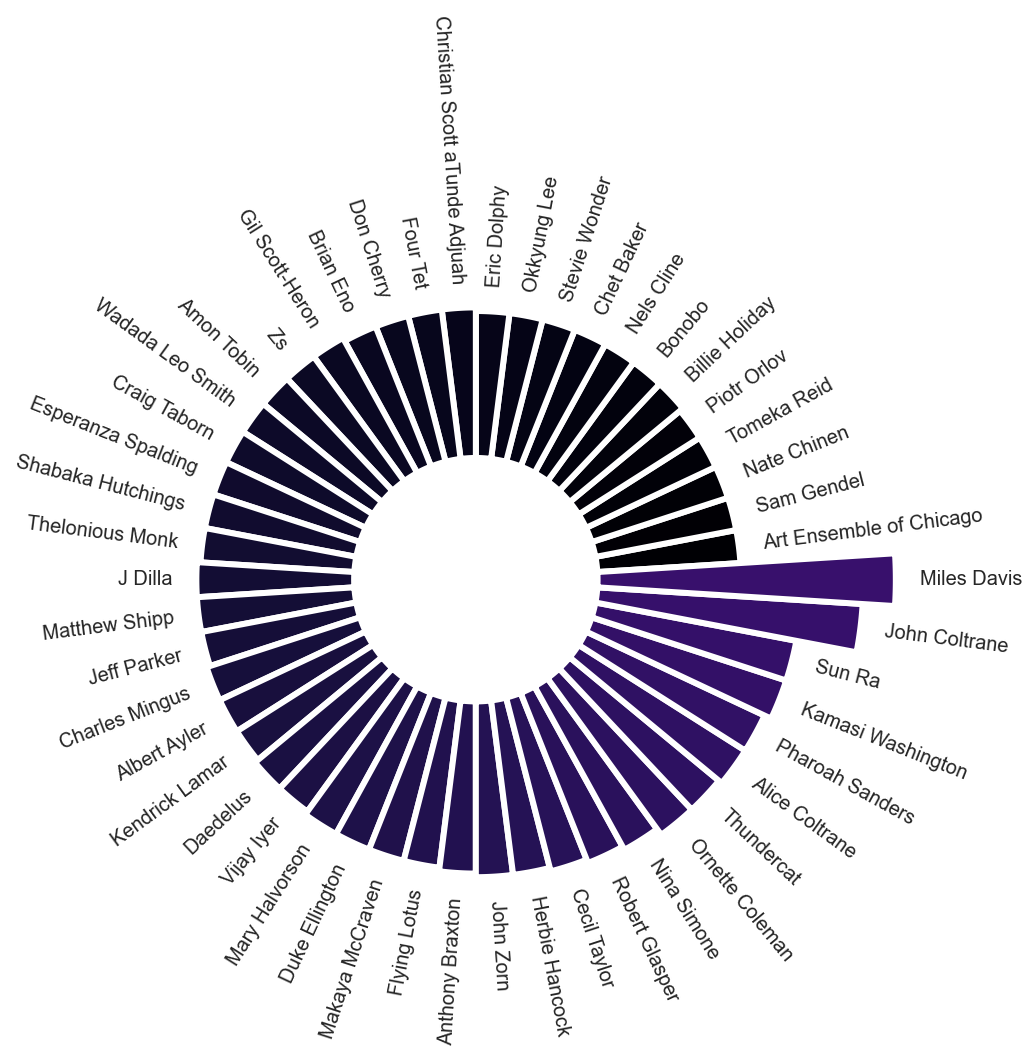

In [2458]:
# import pandas for data wrangling
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors


my_cmap = plt.get_cmap("magma")#tab20c
# Reorder the dataframe
dfment = dfment.sort_values(by=['Count'])

# initialize the figure
plt.figure(figsize=(10,8))
ax = plt.subplot(111, polar=True)

# fig=plt.figure()
# fig.set_figheight(20)
# fig.set_figwidth(20)

plt.axis('off')

# Constants = parameters controling the plot layout:
upperLimit = 100
lowerLimit = 20
labelPadding = 4

# Compute max and min in the dataset
max = dfment['Count'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * dfment.Count + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(dfment.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(dfment.index)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=3, 
    edgecolor="white",
    #color="#61a4b2",
    color=my_cmap.colors,
)

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, dfment["Word"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor") 
    
#plt.tight_layout()
plt.savefig('../img/circbar_top_mentions.png')  

**Also created separate script for above (def_circbar.py)**

In [ ]:
import pickle
#pickle.dump(count_matrix, open('count_matrix_tiny.p', 'wb'))


## Add Emotions

In [1783]:
import pandas as pd
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer

import time
import pandas as pd
import requests

from tqdm import tqdm

def text_emotion(df, column):
    '''
    Takes a DataFrame and a specified column of text and adds 10 columns to the
    DataFrame for each of the 10 emotions in the NRC Emotion Lexicon, with each
    column containing the value of the text in that emotions
    INPUT: DataFrame, string
    OUTPUT: the original DataFrame with ten new columns
    '''

    df_emo = df.copy()

    filepath = ('../data/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
    emolex_df = pd.read_csv(filepath,
                            names=["word", "emotion", "association"],
                            sep='\t')
    emolex_words = emolex_df.pivot(index='word',
                                   columns='emotion',
                                   values='association').reset_index()
    emotions = emolex_words.columns.drop('word')
    emo_df = pd.DataFrame(0, index=df.index, columns=emotions)

    stemmer = SnowballStemmer("english")

    
    book = ''
    chapter = ''
    
    with tqdm(total=len(list(df_emo.iterrows()))) as pbar:
        for i, row in df_emo.iterrows():
            pbar.update(1)
            document = word_tokenize(df_emo.loc[i][column])
            for word in document:
                word = stemmer.stem(word.lower())
                emo_score = emolex_words[emolex_words.word == word]
                if not emo_score.empty:
                    for emotion in list(emotions):
                        emo_df.at[i, emotion] += emo_score[emotion]

    df_emo = pd.concat([df_emo, emo_df], axis=1)

    return df_emo

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1784]:
df_emo2 = text_emotion(df, 'review_lem')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 624/624 [16:39<00:00,  1.60s/it]


In [1775]:
df_emo2.head(2)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


revID                 artist        album  score   genre  \
0      0             Sam Gendel  Fresh Bread    6.5    Jazz   
1      1  Femi Kuti / Made Kuti     Legacy +    7.8  Global   

                                              review  \
0  Fifty-two tracks deep, this archival compendiu...   
1  On the duo’s generation-spanning double album,...   

                                           othercat2  best  \
0   Sam Gendel, Jay Balfour,    Sam Gendel, cover...     0   
1   Femi Kuti, Made Kuti, Joey Akan, Global,    F...     0   

                                        review_clean  \
0  fiftytwo tracks deep this archival compendium ...   
1  on the duo’s generationspanning double album f...   

                                      othercat_clean  ... anger anticipation  \
0   sam gendel, jay balfour,    sam gendel, cover...  ...     4           17   
1   femi kuti, made kuti, joey akan, global,    f...  ...     8           10   

  disgust fear joy  negative  positive  sadness  surprise  trust  
0       1    6   8         9        16        8         7      9  
1       6    6   9        13        34       10         9     16  

[2 rows x 26 columns]

### count words and standardize the emotion counts

In [1778]:
from nltk import tokenize
df_emo3 = df_emo2.copy()
df_emo3['word_count'] = df_emo3['review_lem'].apply(tokenize.word_tokenize).apply(len)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1779]:
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1780]:
for emotion in emotions:
    df_emo3[emotion] = df_emo3[emotion] / df_emo3['word_count']

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1781]:
df_emo3.head(2)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


revID                 artist        album  score   genre  \
0      0             Sam Gendel  Fresh Bread    6.5    Jazz   
1      1  Femi Kuti / Made Kuti     Legacy +    7.8  Global   

                                              review  \
0  Fifty-two tracks deep, this archival compendiu...   
1  On the duo’s generation-spanning double album,...   

                                           othercat2  best  \
0   Sam Gendel, Jay Balfour,    Sam Gendel, cover...     0   
1   Femi Kuti, Made Kuti, Joey Akan, Global,    F...     0   

                                        review_clean  \
0  fiftytwo tracks deep this archival compendium ...   
1  on the duo’s generationspanning double album f...   

                                      othercat_clean  ... anticipation  \
0   sam gendel, jay balfour,    sam gendel, cover...  ...     0.026034   
1   femi kuti, made kuti, joey akan, global,    f...  ...     0.017544   

    disgust      fear       joy  negative  positive   sadness  surprise  \
0  0.001531  0.009188  0.012251  0.013783  0.024502  0.012251  0.010720   
1  0.010526  0.010526  0.015789  0.022807  0.059649  0.017544  0.015789   

      trust  word_count  
0  0.013783         653  
1  0.028070         570  

[2 rows x 27 columns]

In [1782]:
df_emo3.describe()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


revID       score        best   totalwords       anger  \
count  624.000000  615.000000  624.000000   624.000000  624.000000   
mean   311.500000    7.428618    0.070513   710.939103    0.009055   
std    180.277564    1.157300    0.256215   289.938621    0.005644   
min      0.000000    1.000000    0.000000     7.000000    0.000000   
25%    155.750000    7.000000    0.000000   537.500000    0.005323   
50%    311.500000    7.600000    0.000000   645.000000    0.008024   
75%    467.250000    8.000000    0.000000   815.250000    0.011761   
max    623.000000   10.000000    1.000000  2157.000000    0.040073   

       anticipation     disgust        fear         joy    negative  \
count    624.000000  624.000000  624.000000  624.000000  624.000000   
mean       0.021551    0.005826    0.011070    0.018480    0.024874   
std        0.007659    0.004830    0.006807    0.007609    0.010078   
min        0.000000    0.000000    0.000000    0.000000    0.000000   
25%        0.016380    0.002654    0.006534    0.013319    0.018322   
50%        0.021173    0.004912    0.010050    0.017787    0.023715   
75%        0.026029    0.007683    0.014229    0.022781    0.030600   
max        0.058407    0.049180    0.063752    0.043517    0.072860   

         positive     sadness    surprise       trust   word_count  
count  624.000000  624.000000  624.000000  624.000000   624.000000  
mean     0.043683    0.016039    0.009816    0.021585   741.918269  
std      0.011772    0.007478    0.005099    0.007994   311.733791  
min      0.000000    0.000000    0.000000    0.000000     7.000000  
25%      0.036972    0.011045    0.006751    0.016302   563.000000  
50%      0.043690    0.015038    0.009126    0.021167   671.000000  
75%      0.051282    0.019881    0.012369    0.026405   849.500000  
max      0.088477    0.054645    0.030756    0.057181  2308.000000

### Idea - to use emotions either as levers or simply descriptive attributes of an albums review (radars or otherwise)

## MERGE: Wide and Long DF + emotion 

In [1799]:
# keep only emotion columsn
df_emo_mrg = df_emo3[['revID','anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']]
df_emo_mrg.columns

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['revID', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative',
       'positive', 'sadness', 'surprise', 'trust'],
      dtype='object')

In [2510]:
df_genre_stream_emo_long = df_genre_stream_long.merge(df_emo_mrg,on='revID', how='left')

In [2511]:
df_genre_stream_emo_wide = df_genre_stream_wide.merge(df_emo_mrg,on='revID', how='left')

### output to csv

In [2512]:
# Long file
df_genre_stream_emo_long.set_index('artist')
df_genre_stream_emo_long.to_csv(r'../data/df_genre_stream_emo_long.csv')

In [2513]:
# Wide file
df_genre_stream_emo_wide.set_index('artist')
df_genre_stream_emo_wide.to_csv(r'../data/df_genre_stream_emo_wide.csv')

### Data Viz - Emotion - Polar Chart

In [2475]:
# Transpose per artist
df_emoviz = df_genre_stream_emo_wide[['revID','anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']]
df_emoviz = df_emoviz.head(1)
print(df_emoviz)

   revID     anger  anticipation   disgust      fear       joy  negative  \
0    0.0  0.006126      0.026034  0.001531  0.009188  0.012251  0.013783   

   positive   sadness  surprise     trust  
0  0.024502  0.012251   0.01072  0.013783  


In [2476]:
# transpose
df_emoviz_T = df_emoviz.T
df_emoviz_T = df_emoviz_T.iloc[1:]
df_emoviz_T.rename(columns={0:'emo_score'}, inplace=True )
df_emoviz_T.index.name = 'emotions'
df_emoviz_T

emo_score
emotions               
anger          0.006126
anticipation   0.026034
disgust        0.001531
fear           0.009188
joy            0.012251
negative       0.013783
positive       0.024502
sadness        0.012251
surprise       0.010720
trust          0.013783

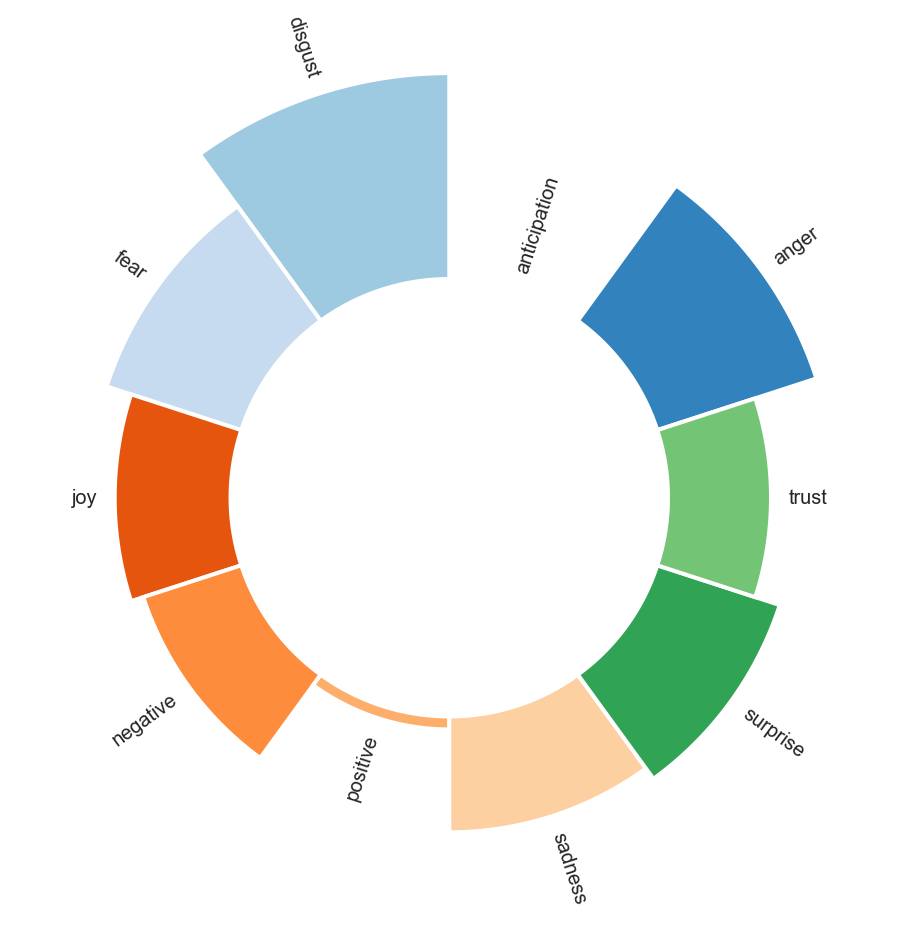

In [2496]:
my_cmap = plt.get_cmap("tab20c")#tab20c

# initialize the figure
plt.figure(figsize=(10,8))
ax = plt.subplot(111, polar=True)
plt.axis('off')

upperLimit = 100
lowerLimit = 50


# Compute max and min in the dataset
max = df_emoviz_T['emo_score'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * df_emoviz_T.emo_score + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(df_emoviz_T.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(df_emoviz_T.index)+1))
angles = [element * width for element in indexes]

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    #color="#61a4b2",
    color=my_cmap.colors,
)

# little space between the bar and the label
labelPadding = 4

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, df_emoviz_T.index):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor") 

In [1209]:
df.columns

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['Unnamed: 0', 'artist', 'album', 'score', 'genre', 'review',
       'othercat2', 'best', 'review_clean', 'othercat_clean', 'artist_clean',
       'album_clean', 'revdate', 'review_lem', 'review_clean2', 'totalwords'],
      dtype='object')

In [1210]:
df_genre.head(3)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0                      artist             album  score   genre  \
0           0                  Sam Gendel       Fresh Bread    6.5    Jazz   
1           1       Femi Kuti / Made Kuti          Legacy +    7.8  Global   
2           2  Archie Shepp / Jason Moran  Let My People Go    7.5    Jazz   

                                              review  \
0  Fifty-two tracks deep, this archival compendiu...   
1  On the duo’s generation-spanning double album,...   
2  These live sets between the saxophonist and pi...   

                                           othercat2  best  \
0   Sam Gendel, Jay Balfour,    Sam Gendel, cover...     0   
1   Femi Kuti, Made Kuti, Joey Akan, Global,    F...     0   
2   Archie Shepp, Jason Moran, Madison Bloom,    ...     0   

                                        review_clean  \
0  fiftytwo tracks deep this archival compendium ...   
1  on the duo’s generationspanning double album f...   
2  these live sets between the saxophonist and pi...   

                                      othercat_clean  ... west coast swing,  \
0   sam gendel, jay balfour,    sam gendel, cover...  ...                 0   
1   femi kuti, made kuti, joey akan, global,    f...  ...                 0   
2   archie shepp, jason moran, madison bloom,    ...  ...                 0   

  western swing, witch house, wonky, yacht rock,  yé-yé,  zamrock,  zeuhl,  \
0              0            0      0           0       0         0       0   
1              0            0      0           0       0         0       0   
2              0            0      0           0       0         0       0   

   zouk,  zydeco,  
0      0        0  
1      0        0  
2      0        0  

[3 rows x 567 columns]

In [1175]:
mbcsv = open('/Users/chrischan/Documents/02_Class/Metis/bootcamp/githubrepo/Metis_proj5/data/mbrainz_genres.csv', 'r')
mbread = mbcsv.read()
print(mbread)

acid house,
acid jazz,
acid rock,
acid techno,
acoustic blues,
acoustic rock,
afoxê,
afrobeat,
alternative country,
alternative dance,
alternative folk,
alternative hip hop,
alternative metal,
alternative pop,
alternative punk,
alternative rock,
ambient,
ambient dub,
ambient house,
ambient techno,
americana,
anarcho-punk,
aor,
arena rock,
art pop,
art punk,
art rock,
atmospheric black metal,
audiobook,
avant-garde,
avant-garde jazz,
avant-garde metal,
avant-garde pop,
avant-prog,
bachata,
ballad,
barbershop,
bardcore,
baroque,
bass house,
beat music,
bebop,
bhangra,
big band,
big beat,
black metal,
blackened death metal,
blackgaze,
bleep techno,
blue-eyed soul,
bluegrass,
blues,
blues rock,
bolero,
bolero son,
bongo flava,
boogie rock,
boogie-woogie,
boom bap,
bossa nova,
bounce,
breakbeat,
breakbeat hardcore,
breakcore,
breaks,
britpop,
broken beat,
brostep,
brutal death metal,
bubblegum pop,
cajun,
calypso,
candombe,
canterbury scene,
cantopop,
carnatic classical,
celtic,
celtic punk

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1178]:
_mblist = mbread.split(",")
mbcsv.close()

mblist = []
for element in _mblist:
    mblist.append(element.strip())

mblist.pop() # last element was blank
print(mblist)

['acid house', 'acid jazz', 'acid rock', 'acid techno', 'acoustic blues', 'acoustic rock', 'afoxê', 'afrobeat', 'alternative country', 'alternative dance', 'alternative folk', 'alternative hip hop', 'alternative metal', 'alternative pop', 'alternative punk', 'alternative rock', 'ambient', 'ambient dub', 'ambient house', 'ambient techno', 'americana', 'anarcho-punk', 'aor', 'arena rock', 'art pop', 'art punk', 'art rock', 'atmospheric black metal', 'audiobook', 'avant-garde', 'avant-garde jazz', 'avant-garde metal', 'avant-garde pop', 'avant-prog', 'bachata', 'ballad', 'barbershop', 'bardcore', 'baroque', 'bass house', 'beat music', 'bebop', 'bhangra', 'big band', 'big beat', 'black metal', 'blackened death metal', 'blackgaze', 'bleep techno', 'blue-eyed soul', 'bluegrass', 'blues', 'blues rock', 'bolero', 'bolero son', 'bongo flava', 'boogie rock', 'boogie-woogie', 'boom bap', 'bossa nova', 'bounce', 'breakbeat', 'breakbeat hardcore', 'breakcore', 'breaks', 'britpop', 'broken beat', 'b

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1137]:
from gensim.corpora.dictionary import Dictionary

def vectorize_vis(data, min_df,max_df):
    vec = CountVectorizer(stop_words=my_stop_words, min_df=min_df, max_df=max_df) #, ngram_range=(1, 3)
    doc_word = vec.fit_transform(data)
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    dictionary = Dictionary([feature_names])
    
    return doc_word, feature_names, id2word, dictionary

In [1138]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

def lda_vis(doc_word, feature_names, id2word, dictionary, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)    
    topics = model.print_topics(num_words=50)
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)

    vis_data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
    return vis_data

In [1147]:
doc_word, feature_names, id2word, dictionary = vectorize_vis(df_genre_nouns['review_lem'], 0.10,.75)
vis_data = lda_vis(doc_word, feature_names, id2word, dictionary, 10)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['2021', 'accessibility', 'advertising', 'albums', 'back', 'bandcamp', 'berlin', 'best', 'breakthroughs', 'buy', 'careers', 'chicago', 'contact', 'content', 'critical', 'features', 'festival', 'galleries', 'grammys', 'guides', 'help', 'home', 'influences', 'liner', 'lists', 'longform', 'masthead', 'music', 'new', 'news', 'notes', 'paris', 'photo', 'picks', 'pitch', 'podcast', 'radio', 'records', 'results', 'reviews', 'rising', 'sign', 'sk


Topic  0
0.027*"track" + 0.023*"record" + 0.021*"thing" + 0.020*"sound" + 0.018*"guitar" + 0.015*"group" + 0.014*"rock" + 0.014*"percussion" + 0.014*"moment" + 0.014*"part" + 0.013*"voice" + 0.013*"place" + 0.013*"piece" + 0.013*"idea" + 0.012*"melody" + 0.012*"word" + 0.011*"project" + 0.011*"musician" + 0.011*"feel" + 0.011*"improvisation" + 0.010*"scene" + 0.010*"drum" + 0.009*"cover" + 0.009*"feature" + 0.009*"point" + 0.009*"player" + 0.009*"sense" + 0.008*"name" + 0.008*"city" + 0.008*"duo" + 0.008*"play" + 0.007*"folk" + 0.007*"solo" + 0.007*"harmony" + 0.007*"use" + 0.007*"horn" + 0.007*"something" + 0.007*"debut" + 0.007*"john" + 0.007*"star" + 0.007*"pop" + 0.007*"collaborator" + 0.007*"room" + 0.006*"note" + 0.006*"lead" + 0.006*"composition" + 0.006*"move" + 0.006*"share" + 0.006*"result" + 0.006*"line"

Topic  1
0.050*"track" + 0.031*"sound" + 0.020*"piano" + 0.019*"group" + 0.016*"pianist" + 0.015*"trio" + 0.014*"record" + 0.014*"moment" + 0.014*"sense" + 0.014*"solo" + 

In [1148]:
pyLDAvis.display(vis_data)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=500)

index = similarities.MatrixSimilarity(lsi[corpus])

text_input = 'Franconia Amber'

def get_beer_keywords(text_input):
    input_beer_keywords = []
    for item in sorted(corpus_tfidf[beers[beers.name == text_input].index[0]], key = lambda x: -x[1])[:5]:
        input_beer_keywords.append(dictionary[item[0]])
    return input_beer_keywords

beers['keywords'] = beers.name.map(get_beer_keywords)
get_beer_keywords(text_input)

def get_similar_beers(text_input):
    try:
        doc = documents[beers[beers.name == text_input].index[0]]
        beer_name_inputted = 1
    except IndexError:
        doc = text_input
        beer_name_inputted = 0
    vec_bow = dictionary.doc2bow(doc.lower().split())
    vec_lsi = lsi[vec_bow]

    sims = index[vec_lsi]
    similar_beers = []
    for beer in sorted(enumerate(sims), key = lambda x: -x[1])[beer_name_inputted:beer_name_inputted+5]:
        similar_beers.append((beer[0],beer[1]))

    return similar_beers

beers['similar_beers'] = beers.name.map(get_similar_beers)
get_similar_beers(text_input)

similar_beers = beers.similar_beers.iloc[0]

def get_recs_from_input(text_input):
    beer_name_inputted = True

    similar_beer_ids = list(beers[beers.name == text_input].similar_beers)
    similar_beers = [beer[0] for beer in similar_beer_ids[0]]
    similar_beers = beers.iloc[similar_beers]
    return (similar_beers ,beer_name_inputted)


get_recs_from_input(text_input)[0]

### Topic Modeling

In [805]:
def lsa(doc_word, feature_names, num_topics):
    model = TruncatedSVD(num_topics)
    doc_topic = model.fit_transform(doc_word)
    for ix, topic in enumerate(model.components_):
        print("\nTopic ", ix)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-21:-1]]))

def nmf(doc_word, feature_names, num_topics):
    model = NMF(num_topics)
    doc_topic = model.fit_transform(doc_word)
    for ix, topic in enumerate(model.components_):
        print("\nTopic ", ix)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-75:-1]]))

def lda(doc_word, feature_names, id2word, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)
    topics = model.print_topics(num_words=50)
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)
        

def corex(doc_word, feature_names, num_topics):
    words = list(np.asarray(feature_names))
    model = corextopic.Corex(n_hidden=num_topics, words=words, seed=1, max_iter=200)
    model.fit(doc_word, words=words, docs=data) # where data = df["Lemmatized"]
    topics = model.get_topics()
    for n,topic in enumerate(topics):
        topic_words,_ = zip(*topic)
        print('{}: '.format(n) + ','.join(topic_words))
        
def vectorize_2(data, min_df,max_df):
    vec = CountVectorizer(stop_words=my_stop_words,  min_df=min_df , max_df=max_df) #ngram_range=(1, 3)
    doc_word = vec.fit_transform(data)
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    
    return doc_word, feature_names, id2word        

### NMF with min/max df

In [843]:
data_grg = df_sent_grg["lemmatized"]
#data_pos = df_sent_grg_pos["lemmatized"]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [871]:
doc_word, feature_names, id2word= vectorize_2(data_grg,.03,.55)
nmf(doc_word, feature_names, 5)


Topic  0
hand, kramer, parent, leave, big, move, point, thank, happen, mean, maybe, walk, life, salad, much, even, laugh, apartment, eat, stop, need, play, door, man, kid, face, sorry, sit, check, father, hear, work, turn, table, god, dinner, hold, arm, use, dad, year, lunch, mother, find, please, ever, nice, money, wear, job, buy, kind, break, fine, mind, try, room, another, chuckle, anymore, clothe, shirt, shake, whole, place, pick, raise, head, heh, plan, live, may, help, people

Topic  1
car, bar, first, space, candy, move, dollar, park, big, people, maybe, pull, lot, even, pay, parking, walk, great, front, head, spot, door, sorry, start, leave, buy, kramer, need, help, turn, mean, hat, away, window, day, wait, stop, try, drive, name, nobody, anything, hear, sure, stand, coat, believe, kid, please, open, run, hospital, twenty, pick, wrong, might, change, excuse, fine, another, minute, doubt, ask, store, susan, father, chair, heh, bother, nice, listen, fall, much, elaine

Topic  2


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


## LDA with min/max df

In [845]:
from gensim.corpora.dictionary import Dictionary

def vectorize_vis(data, min_df,max_df):
    vec = CountVectorizer(stop_words=my_stop_words, min_df=min_df, max_df=max_df) #, ngram_range=(1, 3)
    doc_word = vec.fit_transform(data)
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    dictionary = Dictionary([feature_names])
    
    return doc_word, feature_names, id2word, dictionary

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [846]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

def lda_vis(doc_word, feature_names, id2word, dictionary, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)    
    topics = model.print_topics(num_words=50)
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)

    vis_data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
    return vis_data

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [868]:
doc_word, feature_names, id2word, dictionary = vectorize_vis(data_grg, 0.03,.65)

vis_data = lda_vis(doc_word, feature_names, id2word, dictionary, 5)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Topic  0
0.010*"elaine" + 0.010*"kramer" + 0.010*"something" + 0.009*"talk" + 0.008*"call" + 0.008*"woman" + 0.008*"happen" + 0.008*"time" + 0.007*"little" + 0.007*"even" + 0.007*"give" + 0.007*"george" + 0.007*"anything" + 0.007*"people" + 0.007*"show" + 0.007*"never" + 0.007*"stop" + 0.007*"need" + 0.007*"great" + 0.006*"mean" + 0.006*"yes" + 0.006*"day" + 0.006*"try" + 0.006*"nothing" + 0.006*"leave" + 0.005*"maybe" + 0.005*"buy" + 0.005*"ask" + 0.005*"nice" + 0.005*"name" + 0.005*"big" + 0.005*"start" + 0.005*"hear" + 0.005*"care" + 0.005*"laugh" + 0.005*"sorry" + 0.005*"friend" + 0.005*"point" + 0.005*"believe" + 0.005*"excuse" + 0.004*"live" + 0.004*"funny" + 0.004*"meet" + 0.004*"lot" + 0.004*"minute" + 0.004*"phone" + 0.004*"wait" + 0.004*"first" + 0.004*"always" + 0.004*"guy"

Topic  1
0.012*"call" + 0.010*"yes" + 0.009*"something" + 0.009*"george" + 0.008*"guy" + 0.008*"big" + 0.008*"little" + 0.008*"try" + 0.008*"wait" + 0.007*"give" + 0.007*"talk" + 0.007*"happen" + 0.006*

In [869]:
pyLDAvis.display(vis_data)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
